--- 
Final project for the course in Computational Statistics | Summer 2021, M.Sc. Economics, Bonn University | [Jonathan Willnow](https://github.com/JonathanWillnow)


# Partitioning and Hierachical Clustering and their Validation <a class="tocSkip">   
    
    
---
      


Xu,D., Tian,Y. A comprehensive Survey of Clustering Algorithms, Ann. Data. Sci 2, 165-193 (2015)      Minhua Chen et al(2021): Deep Clustering with Measure Propagation


##### Downloading and viewing this notebook:

* To view this notebook, the best way is to download the notebook which is contained in the repository on [GitHub](https://github.com/OpenSourceEconomics/ose-data-science-course-project-JonathanWillnow). Other viewing options like _MyBinder_ or _NBViewer_ may have issues with displaying images or coloring of certain parts (missing images can be viewed in the folder [files](https://github.com/OpenSourceEconomics/ose-data-science-course-project-JonathanWillnow) on GitHub).




In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as tools
import scipy.stats as scipy
import sklearn.datasets as sk_data
import sklearn.cluster as sk_cluster
import sklearn_extra.cluster as skx_cluster
import sklearn.preprocessing as sk_preprocessing
import sklearn.metrics as sk_metrics
import random
import kneed


import time

from IPython.display import HTML

In [2]:
%matplotlib inline
#sns.set_context('talk')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 50, 'linewidths':0}

---
# Table of Contents
---

 1. [Introduction](#introduction)
 2. [The Tracking Underreported Financial Flows (TUFF) methodology](#section2)
 3. [Descriptive Statistics & Allocation of Chinese Development Finance](#section3)
   * 3.1 [The Distribution of Project Types](#section3.1)
   * 3.2 [Sectoral Distribution](#section3.2)  
   *  3.3 [Finance Form of Projects](#section3.3)  
   *  3.4 [Cross-country Distribution of Chinese Development Finance](#section3.4)  
   *  3.5 [Factors that determined Allocation of Chinese Development Finance](#section3.5)  
       *  3.5.1 [Extension - Descriptive Plots](#section3.5.1)  
       *  3.5.2 [Physical Project Inputs](#section3.5.2)  
       *  3.5.3 [Foreign Exchange Reserves](#section3.5.3)
   *  3.6 [Mixed Effect Models](#section3.6) 
 4. [Identification](#section4)
 5. [Empirical Strategy](#section5)
    *  5.1 [IV Strategy](#section5.1)
    *  5.2 [Checking Parallel Trends Assumption](#section5.2)
 6. [Does Chinese Development Finance Promote Growth?](#section6)
    *  6.1 [Main Results](#section5.1)
    *  6.2 [Extension - Visual Representation of Results](#section6.2)
    *  6.3 [ Extension - Checking Instrument Validity](#section6.3)
    *  6.4 [Timing of the Growth Effects](#section6.4)
    *  6.5 [How does Chinese Development Finance cause Growth?](#section6.5)
    *  6.6 [Robustness Checks](#section6.6)
 7. [Conclusion](#section7)
 8. [References and Literature](#section8)







# Introduction to Clustering

Every day, large amounts of data are collected by many heterogenous individuals. To create information from this data, clustering is an essential part in the process to identify patterns or groups within the collected data. For instance consider the database of a food-delivery chain that records purchases of its customers. An appropriate clustierng algorithm could group the customers by similar patterns within their order history. This could provide a deeper understanding of the demand side.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf
Clustering poses special challenges: Unlike other methods in Data Science, clustering does not try to predict an output. We only observe the input variables, but not the output variable. 




### What is a Cluster

Clusters are loosely defined as groups of data objects that are more similar to other objects in their cluster than they are to data objects in other clusters. In practice, clustering helps identify two qualities of data:

**Meaningfulness**

> Clusters that are meaningful expand the users domain knowledge. 

**Usefulness**

> Useful clusters serve as an intermediate step in a data pipeline. For example, businesses use clustering for customer segmentation. The clustering results segment customers into groups with similar purchase histories, which businesses can then use to create targeted advertising campaigns.

# Apply own example for Usefulness and Meaningfullness

Since the choice of feature types and measurement levels depends on the data, many clustering algorithms have been developed. 
https://www.intechopen.com/chapters/60501

In fact, there are so many approaches that entire categories of clustering algorithms exists. Each of these categories has its own unique strengths and weaknesses. Certain clustering algorithms will result in more natural cluster assignments depending on the input data, some are better at detecting unusual shapes of clusters.

The whole process of clustering is illustrated in the following picture:


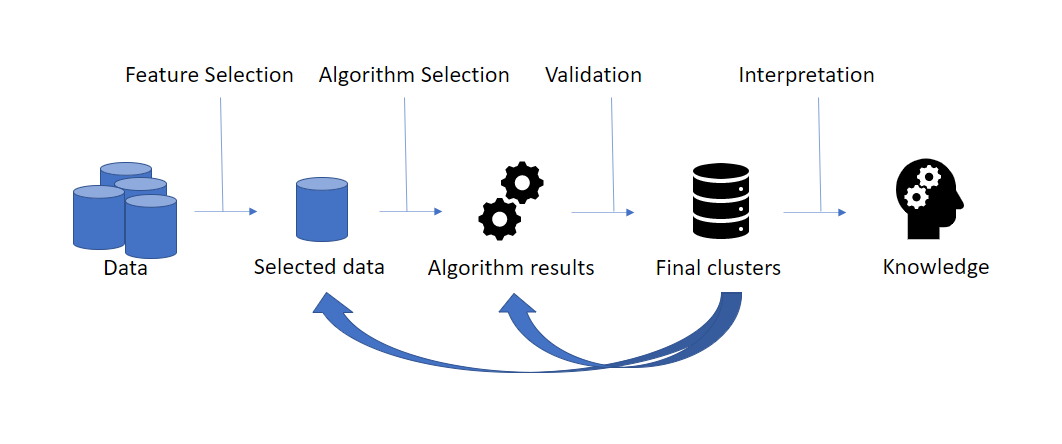
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf


http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf

Selecting the right features and an appropriate clustering algorithm for the data at hand is often times quite difficult. There are so many choices to make, depending on the characteristics of the clusters, the features of the dataset, the number of outliers, and the number of data objects. Thats not all as the user still needs to validate his results and finally interpret them.

https://realpython.com/k-means-clustering-python/


Clustering is a major tool in many fields. It can be used for different sorts of applications:

* Data reduction. Clustering helps to compress the information included in a dataset, especially when the amount of available data is large and the processing of the whole data becomes very unfeasible. Applying clustering helps to reduce the dataset into a number of clusters wich can than be processed on further.

* Hypothesis generation. Clustering can be used to infer some hypotheses concerning the data at hand. In our example from earlier on, we find out that the business has three significant groups of customers. Based on this three clusters, we can set up hypothesis about their behaviour (Older individuals tend to pay cash,...)

* Hypothesis testing / verification. Clustering is used to validate  a specific hypothesis. Considering the hypothesis from before (Older individuals tend to pay cash), clustering can suport this hypothesis if it forms a cluster that coresponds to the hypothesis.

* Prediction based on groups. Clustering forms clusters that can be characterized by the features of the observations that belong to these clusters. New observations, for instance new customers can be assigned into these specified clusters based on their similarity to the clusters’ features. This helps to extract knowledge that is related the data.



## Distance Measuring

Before jumping into the different algorithms for clustering, it is helpful to reconsider how to measure the distances of elements relative to each other in order to decide which elements belong in which group. A distance between any pair of elements or vectors satisfies four porperties:

>1. Symmetrie, $d(i,j) = d(j,i)$
>2. Poitive Definiteness, $d(i,j) > 0$ and $d(i,j) = 0$ if and only if $i=j$
>3. Triangel Inequality, $d(i,j) <= d(i,k) + d(k,j)$

From these assumptions follows the Minkowskie distance, which is the traditional way to measure distances:

The Minkowski distance with order p between two elements (or vectors) $i,j$ is defined as:



\begin{equation}
D(i,j) = (|i - j|^p)^{(1/p)}
\end{equation}


taking $p$ = 1 we have the Manhattan distance, also know as taxi-cab distance and with $p$ = 2 we have the Euclidean distance. For most common hierachical clustering, the Euclidean distance is the go to distance.
http://i2pc.es/coss/Docencia/SignalProcessingReviews/Murtagh2012.pdf


# Partitioning and Hierachical Clustering methods

Figure 1 displays the difference between partitional clustering (b) and hierachical clustering (c) of a dataset (a). There are two more categories, Density-based clustering and Grid-based clustering. As the title suggests, this notebook explores the first two aformentioned categories. I will explore several methods for partitioning and hierachical clustering and their validation. 
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf




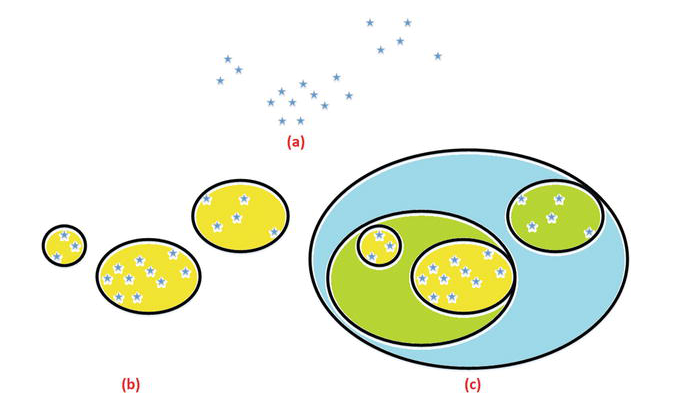
https://www.intechopen.com/chapters/60501



## Data and Preparations

For the introduction of the algorithms, I created random samples using the scikit-learn function make_blobs(), which generates isotropic Gaussian blobs for clustering. The data needs to be standardized, since in a real world context the dataset would most likely contain features measured in different units.

In [3]:
random.seed(10)

In [4]:
features, true_labels = sk_data.make_blobs(n_samples=200, centers=3, cluster_std=2.75, random_state=42)
blobs_df = pd.DataFrame(features, columns = ["x1", "x2"])
blobs_df["label"] = true_labels

In [5]:
# Standartization
scaler = sk_preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)
blobs_df = pd.DataFrame(features_scaled, columns = ["x1", "x2"])
blobs_df["label"] = true_labels
blobs_df.head(5)

x1        x2  label
0  2.130821  0.256044      1
1 -1.526985  1.410367      0
2 -1.001302 -1.565832      2
3 -1.742569 -1.768325      2
4 -1.299245 -0.872534      2

##### Plotting the generated and standardized dataset

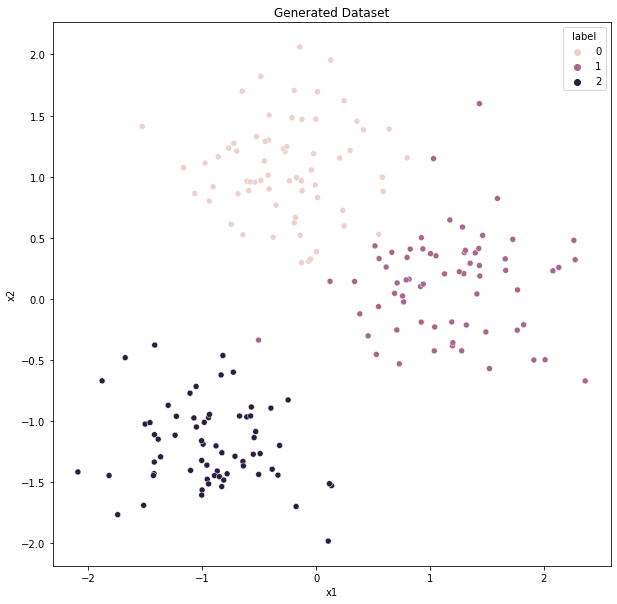

In [6]:
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.scatterplot(x= blobs_df.x1, y=blobs_df.x2, hue=blobs_df.label)
ax.set_title("Generated Dataset");

In [81]:
def generate_complexdata(plotting):
    
    # Generate data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmkAAAJcCAYAAACixjPMAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAACP00lEQVR4nOzdd5hcZdk/8O8z50wv23vJ7qZuOsmSBEKVDipVpFhABEWxoqLo77W8+oq+VsSGClgQXgQFRIo06SQktPSezfZeZnb6Oc/vj9lMMplNspudmTO78/1cFxfMvWfOuXdJdu99yv0IKSWIiIiIKLuYjE6AiIiIiJKxSCMiIiLKQizSiIiIiLIQizQiIiKiLMQijYiIiCgLsUgjIiIiykIs0oiIjoEQ4hohxMtG50FE0xeLNCJKGSHEFUKINUKIESFE9+h/f0oIIYzO7VBCiP8IIT6epnvXCSGkEMI3+k+XEOIxIcRZE7hHRopAFptE2YtFGhGlhBDiZgA/B/C/AMoBlAH4JIDVACwZzkXN5POOIF9K6QKwBMDTAP4hhLjG2JSIaKpgkUZEkyaEyAPwHQCfklI+KKX0ypi3pJRXSylDo9dZhRA/EkLsGx1d+o0Qwj76sdOEEK1CiJtHR+E6hBDXHvSM8bz3FiFEJ4C7hRAFo6NXPUKIgdH/rh69/nsATgZwx+hI1x2j8XlCiKeFEP1CiG1CiMsPen6REOJRIcSwEGItgJnj/fpIKTullD8H8C0APxBCmEbv+VUhxC4hhFcIsVkIcfFovBHAbwCcMJrf4Gj8AiHEW6M5tAghvnVQfjYhxF+EEH1CiEEhxBtCiLL9/3+EEH8Y/Zq2CSG+K4RQDvccIsoOLNKIKBVOAGAF8MhRrvsBgDkAlgKYBaAKwH8d9PFyAHmj8esA/FIIUTCB9xYCmAHgBsS+v909+roWQADAHQAgpfw6gJcA3CSldEkpbxJCOBEb7forgFIAVwL4lRBiwej9fwkgCKACwMdG/5mov4/ee+7o612IFYt5AL4N4C9CiAop5RbERiFfG80vf/T6EQAfAZAP4AIANwohLhr92EdH71MDoGj0/YHRj/0RQBSxr9txAM4G8PEjPIeIsgCLNCJKhWIAvVLK6P6AEOLV0RGdgBDilNF1adcD+IKUsl9K6QXwPwCuOOg+EQDfkVJGpJSPA/ABmDvO9+oAvimlDEkpA1LKPinlQ1JK/+j13wNw6hE+h/cC2CulvFtKGZVSvgngIQCXCSEUAJcC+C8p5YiUciNihc9EtY/+uxAApJR/k1K2Syl1KeX/AdgBYMXh3iyl/I+UcsPo9e8CuO+gzymCWHE2S0qpSSnXSymHR0fTzgPw+dHcuwH8FIlfOyLKQtmyboOIprY+AMVCCHV/oSalPBEAhBCtiP1CWALAAWD9QfsIBADl4PscXOgB8ANwjfO9PVLKYPyDQjgQK0bOBbB/NM4thFCklNoYn8MMACsPmfJTAfx59PkqgJaDPtY85lfiyKpG/90/muNHAHwRQN1o3IVYwTsmIcRKALcBWIjYOj8rgL+NfvjPiI2i3S+EyAfwFwBfH/28zAA6DvramQ75XIgoC3EkjYhS4TUAIQAXHuGaXsSm3xZIKfNH/8kbXVh/NON5rzzkPTcjNq24UkrpAXDKaFwc5voWAC8cdP/80SnAGwH0IDZdWHPQ9bXjyPtQFwPoBrBNCDEDwO8A3ASgaHSqceMR8gNiU7GPAqiRUuYhtp5MAMDo6OO3pZTzAZyI2MjgR0Y/rxCA4oM+L4+Ucv807ljPIaIswCKNiCZNSjmI2JqqXwkhLhNCuIQQJiHEUgDO0Wt0xIqSnwohSgFACFElhDhnHPc/lve6ESvsBoUQhQC+ecjHuwA0HPT6MQBzhBAfFkKYR/85XgjRODry9ncA3xJCOIQQ8xFbAzYuQogyIcRNozl8bfTzcSJWIPWMXnMtYiNkB+dXLYQ4eGesG0C/lDIohFgB4KqDnnG6EGLR6NTsMGLTn5qUsgPAvwH8WAjhGf3/MlMIceoRnkNEWYBFGhGlhJTyh4hN3X0FsdGiLgC/BXALgFdHL7sFwE4ArwshhgE8gwOL6I9mou/9GQA7YqNwrwN48pCP/xyx9WYDQojbR9etnY3YWq12AJ2IbVawjl5/E2LTkZ0A7kFsU8LRDAohRgBsAHA+gA9IKe8CACnlZgA/RmwUsgvAIgCvHPTe5wBsAtAphOgdjX0KwHeEEF7ENk08cND15QAeRKxA2wLgBcSmPIHYiJoFwGYAA6PXVRzhOUSUBYSUHOkmIiIiyjYcSSMiIiLKQizSiIiIiLIQizQiIiKiLMQijYiIiCgLTctmtsXFxbKurs7oNIiIiIiOav369b1SypJD49OySKurq8O6deuMToOIiIjoqIQQY55gwulOIiIioizEIo2IiIgoC7FIIyIiIspC03JNGhEREeWOSCSC1tZWBINBo1M5IpvNhurqapjN5nFdzyKNiIiIprTW1la43W7U1dVBCGF0OmOSUqKvrw+tra2or68f13s43UlERERTWjAYRFFRUdYWaAAghEBRUdGERvtYpBEREdGUl80F2n4TzZFFGhEREVEWYpFGREREOcHlch3x43v37sXChQsndM9rrrkGDz744GTSOiwWaURERERZiEUaERER5RSfz4czzjgDy5Ytw6JFi/DII4/EPxaNRvHRj34UixcvxmWXXQa/3w8AWL9+PU499VQsX74c55xzDjo6OtKeJ4s0IiIiyik2mw3/+Mc/8Oabb+L555/HzTffDCklAGDbtm244YYb8O6778Lj8eBXv/oVIpEIPvOZz+DBBx/E+vXr8bGPfQxf//rX054n+6QRERFRTpFS4tZbb8WLL74Ik8mEtrY2dHV1AQBqamqwevVqAMCHPvQh3H777Tj33HOxceNGnHXWWQAATdNQUVGR9jxZpBEREVFOuffee9HT04P169fDbDajrq4u3r/s0DYZQghIKbFgwQK89tprGc2T051ERESUU4aGhlBaWgqz2Yznn38ezc3N8Y/t27cvXozdd999OOmkkzB37lz09PTE45FIBJs2bUp7nizSiIiIKKdcffXVWLduHZqamnDvvfdi3rx58Y81Njbij3/8IxYvXoz+/n7ceOONsFgsePDBB3HLLbdgyZIlWLp0KV599dW05yn2L5SbTpqamuS6deuMToOIiIgyYMuWLWhsbDQ6jXEZK1chxHopZdOh13IkjYiIiCgLsUgjIiIiykIs0ohoStA1DVLXjU6DiChj2IKDiLKaHo0gPDSAUF8PhMUCe0k5VIcraZs8EdF0w5E0IspqoYE++Nv2QQsGEB0egnf3dmgBv9FpERGlHYs0IspaeiSCYE9XYlBKRFmkEVEOYJFGRNlLCAhT8rcpTnUSUTZ68sknMXfuXMyaNQu33XbbpO/HIo2IspZJVWEvr0qICUWF4nAalBER0dg0TcOnP/1pPPHEE9i8eTPuu+8+bN68eVL35MYBIspqFnceRP0cRLxDMJnNMLs8UG12o9MioiksNNCHQGcb9EgYJrMF9vIqWAuKJnXPtWvXYtasWWhoaAAAXHHFFXjkkUcwf/78Y74nizQiympCUWBxe2Bxe4xOhYimgdBAH0ZamwEZa+mjR8Kx18CkCrW2tjbU1NTEX1dXV2PNmjWTytWw6U4hRI0Q4nkhxBYhxCYhxOfGuEYIIW4XQuwUQrwrhFhmRK5EREQ0PQQ62+IFWpzUY/FJGOuYzcmunzVyJC0K4GYp5ZtCCDeA9UKIp6WUB0/gngdg9ug/KwH8evTfRERERBOmR8ITio9XdXU1Wlpa4q9bW1tRWVk5qXsaNpImpeyQUr45+t9eAFsAVB1y2YUA/iRjXgeQL4SoyHCqRERENE2YzJYJxcfr+OOPx44dO7Bnzx6Ew2Hcf//9eP/73z+pe2bF7k4hRB2A4wAcOnlbBaDloNetSC7k9t/jBiHEOiHEup6enrTkSURERFObvbwKEIeUP8KUtJN8olRVxR133IFzzjkHjY2NuPzyy7FgwYLJ3XNS704BIYQLwEMAPi+lHD70w2O8JXnSF4CU8k4AdwJAU1PTmNcQERFRbtu/OSDVuzsB4Pzzz8f5558/6fvsZ2iRJoQwI1ag3Sul/PsYl7QCqDnodTWA9kzkRkRERNOTtaAoJUVZuhm5u1MA+AOALVLKnxzmskcBfGR0l+cqAENSyo6MJUlEOU1qGiLeYfg72xDs60E0GDA6JSLKIUaOpK0G8GEAG4QQb4/GbgVQCwBSyt8AeBzA+QB2AvADuDbzaRJRrgp7BzGyb0/8tclsgbthDhSrzcCsiChXGFakSSlfxthrzg6+RgL4dGYyIiI6QI9EEOhoPSQWRjTgZ5FGRBmRFbs7iYiyjZQSuqYlx3V9jKuJiFKPRRoR0RhMZjNsxWWJQSF4bigRZQyLNCKiMQghYC0qgb28GiaLFarTA3f9HCh2h9GpEVEW+tjHPobS0lIsXLgwZfdkkUZEdBiK2QJ7aTk8sxrhrpsJs8s96bP4iGh6uuaaa/Dkk0+m9J6GN7MlIsp2JpXfKommk+Y1W7HhkVfg7/fCUejGogtXY8bKeZO65ymnnIK9e/emJsFR/M5DREREOaN5zVasu/cZaOEoAMDf78W6e58BgEkXaqnG6U4iIiLKGRseeSVeoO2nhaPY8MgrBmV0eCzSiIiIKGf4+70TihuJRRoRERHlDEehe0JxI7FIIyIiopyx6MLVUCyJS/IVi4pFF66e1H2vvPJKnHDCCdi2bRuqq6vxhz/8YVL3A7hxgIiIiHLI/s0Bqd7ded9996UivQQs0oiIiCinzFg5L+t2co6F051EREREWYgjaUQEANCjEWihEIRJwGSxwaQoRqdERJTTWKQREbRgAL6WPdACfgCApaAIjrIqmCwWgzMjIspdnO4kynFSSgT7euIFGgCEB/oQ9fsMzIqIiFikEeU4qWmIeIeS4tGDijYiIso8FmlEOU4oClSXJymu2OwGZENENDW1tLTg9NNPR2NjIxYsWICf//znk74n16QR5TghBGxFJYj6hqGHQwAAc14+VFf2dd8mIspWqqrixz/+MZYtWwav14vly5fjrLPOwvz584/5nhxJIyKodgc8M+fC3TAHnlnz4Kyug2LmpgEimp7+9fDTOOfEy7Gk7jScc+Ll+NfDT0/6nhUVFVi2bBkAwO12o7GxEW1tbZO6J0fSiAgAYDJbYGJhRkTT3L8efhrf/ur/IhiIzRx0tHXh21/9XwDABRedlZJn7N27F2+99RZWrlw5qftwJI2IiIhyxu0//F28QNsvGAjh9h/+LiX39/l8uPTSS/Gzn/0MHk/yet+JYJFGREREOaOzvXtC8YmIRCK49NJLcfXVV+OSSy6Z9P1YpBEREVHOKK8snVB8vKSUuO6669DY2IgvfvGLk7rXfizSiIiIKGd89ivXw2a3JsRsdis++5XrJ3XfV155BX/+85/x3HPPYenSpVi6dCkef/zxSd2TGweIiIgoZ+zfHHD7D3+HzvZulFeW4rNfuX7SmwZOOukkSClTkWIcizQiIiLKKRdcdFbKdnKmE4s0IsoauhaFHgxC13UoVhsUHvBORDmMRRrRFKaFgoj6R6BHo1AdDqh2J4Rpai411cNh+DtaER7qBxDr2+aqmwXV7kjdMzQNUotCKCpMipKy+xKR8aSUEEIYncYRTXQ6lEUa0RSlhYLw7t4OPRKOx1wzZsGSl29cUpMQDYzECzQA0CNhBLs74KypT0nhGfWPwN/RiuiIF4rDBWdlDVSHc9L3JSLj2Ww29PX1oaioKGsLNSkl+vr6YLPZxv0eFmlEU1Q04E8o0ADA39kK1emCSZ16f7W1YCApFhnxQWrapIs0LRKGr3lX/Oul+X3w7t0Jz6x5UCzWo7ybiLJddXU1Wltb0dPTY3QqR2Sz2VBdXT3u66fed3IiAgBILZoci0YhpW5ANpOn2OxJMbPbA6FOflpSD4WSCloZjUAPh1ikEU0DZrMZ9fX1RqeRclNz8QoRQRljrZa1qAQm1WxANpOnOFywFpUceG21w1ZSDiEm/21KHGb92eHiRETZgCNpRFOUanfCVT8bgY5W6NEorEUlsBZk73qMo1HMZjgqqmEtLIHUdShWa8oKTsVqg62kHMGeznjMVlIGxTL+tSFERJnGIo1oihJCwOLOiy1+1yVM5qk5gnYwYVJSupvzwH1NsJWUw+xyQ4uEoZgtUOwOjqQRUVZjkUY0xZkUFWCtcVQmVYXJnYepX8oSUa7gmjQiIiKiLMSRNCKiFJOaBi0cAqSEyWpj41wiOiYs0oiIUkgLhxDobEd4sA8AYHbnw1FZA8XKVh9ENDGc7iQiSqGIzxsv0AAg4h1EeHjAwIyIaKpikUZElEIR72BybGhgwmf20fQVGBrBcEcfwiNBo1OhLMfpTiKiFFKdbkSGBpNiU7V/HaWO1CW6tjTjjT8/g8CgD/k1JWj68FkorC01OjXKUhxJIyJKIYs7L+E0CJPFBmtBkYEZUbbwdvXj5V//E4FBHwBgsKUHa+56AiGv3+DMKFtxJI2IKIUUqw3uutnQQkFIKaHabDCZLUanRVnA2zMEPaolxjoH4B/wwupOfRNnmvpYpBERpZjJbJ4WJ0BQatlc9qSYarPAbOfOXxobpzuJiIgywF1RhDlnLEuILbvidLhK8o1JiLIeR9KIiIgywGK3YP4FK1C1tAHBYT+cxXnIq+R6RTo8FmlEREQZYnHYUDK72ug0aIrgdCcRERFRFmKRRkRERJSFWKQRERERZSEWaURERERZiBsHiGhcogE/IsOD0CIRWPLyYXa4IBTF6LSIiKYtQ0fShBB3CSG6hRAbD/Px04QQQ0KIt0f/+a9M50hEQDQYgHf3NgS62hHu74Fvzw6EvUNGp0VENK0ZPd15D4Bzj3LNS1LKpaP/fCcDORHRIaIjPkgt8TibQFcb9Gg0JfeXUkILBRENBSF1PSX3JCKa6gyd7pRSviiEqDMyByIaBymTY7oEMEZ8gvRIGMHebgR7uwAJWItLYCsph8LzLokoxxk9kjYeJwgh3hFCPCGEWHC4i4QQNwgh1gkh1vX09GQyP6JpT3U4ASESYraScpjUyZ9PGfF5EezpHC0EJUK93YgMjz2VqoVCCA8PIjw8BC0cGtf99WgEocF+ePfuhL+jFdGAf9I5ExFlQrZvHHgTwAwppU8IcT6AhwHMHutCKeWdAO4EgKampsn/ek9EcYrdAXfDXIR6u6CFw7AVl8DszkvJvcNDA8mxgT5YC4shDioMowE/vHt2QEYjAACTxQJX3WyotuRDqw8WGuhHoKMFABABEOrvhXvmPKg2W0ryJyJKl6wu0qSUwwf99+NCiF8JIYqllL1G5kWUa4QQMDtdsRE1qUOYUrerU3U4ERkeTIqJQ0buwgN98QINAPRwGJHhwSMWaVo4hGBXe0JMalFoQX9WFWlSSkQDI4iOjECYTFCdrqMWn0Q0/WV1kSaEKAfQJaWUQogViE3P9hmcFlHOEkIAIrVtNyyefIT6eqBHwrFnqCosBYmHTkspEfWPJL13rNih5Fjr5sZaY2eg6IgX3t3b46+FosI9cy4LNaIcZ2iRJoS4D8BpAIqFEK0AvgnADABSyt8AuAzAjUKIKIAAgCukzLLvrkQ0KYrNDvfMudCCAUBKKDYHFKs14RohBCz5hYj6fQlxS17BEe9tMltgL6lAoKvtwL0UBYrdkbpPYJKkpiHQ1XFILIqIb5hFGlGOM3p355VH+fgdAO7IUDpEZBDFYoVisR7xGrMnD5ZgCcL9PYAQsBWVwuxyH/E9QghYi4phspgR6u+DYrPBWlCcVcWPhIR+0DRuPJ6i9iZENHVl9XQnEdF+isUKZ2UNbMWlAAQUqwVCHH2Dukk1w1pQDEt+UdI6t2xgUlTYikrhb9+XEDe7PAZlRETZgkUaTYiuadBDQeiaBsV69NEPolQSJtMxj4JlY4G2nyW/ABISoZ4uCEWBvawytkmDiHIaizQaNy0SQbC7HaG+WB86oapw183mDxOiSTKpZtiLy2DNLwSEgEnht2YimhrNbClLaAF/vEADYmtm/B2t0A85LoiIjo1JNbNAI6I4fjegcdvfIuFgUb8PUosCSmrbMhDRAVLXIXUNQlHTNm0bDfgR8Q1DRqMwe/Kg2p0QJv4eT2QkFmk0bmOtP1Ndbv7mT5RG0YAfwZ4uREe8UN15sBeXQknx7tRowA/vrm2QemxUPNjTCXf97JSdKkFEx4a/JtG4KXYHbKUV8dcmixWO8moIjqIRpYUWDsO3dyfCg33QI2GE+3vga9kDPcXtOSK+4XiBtl+guwOSSxmIDMUhEBo3k6rCXloBS14BpK5DsVhhMk/+gG0iGpsWCiYtM9ACfmihIEyqK2XPGasYk5oGCSB798QSTX8cSaMJESYTVLsDZqeLBRpRmh1uTViq14qN1ZPNWlwGE0fJiQzFIo2IKEspVhvMnvyEmLWoJOnYrMlSHU6462dDdbqg2OxwVNfB4uF6NCKjcbqTiChLmVQVjqpaRPMLoQUDUO0OqE4XhCm1I1zCZILZnQfV4YIEOIJGlCVYpBHlKD0Sga5FYVJVmFROXWcrxWyBkl+YkWcJReEaNKIswiKNKAdFfMMYadkLPRKGyWKFs6YeZmfqFqITEdHkcU0aUY7RQkF49+6M7xrUwyH4mndBCyc3KyYiIuOwSCPKMVo4BOh6QkxGI9AjIYMyIiKisXC6kyjHmNQx/toLAXGEkyP0SBgR7zBCQ/1Q7U5Y8wtT3vWeiIgSsUgjyjGK1QZ7WSUCXe3xmKOyBorVlnCdHo1CCwYgpQ4ZjWCkrRmQElHvMMIDvXA3zEt5KwgiIjqARRpRjhEmBdbiUqguN/RIBIrFAsVmTzi4WwuHMNK6F1GfFwBgMptjhV1nG4DYzlAtFGCRRkSURizSiLJYNBiIHQFkMkGx2WEyW1JyX5OiwuR0H/65I754gQbEirJowA/FZocWDKQkByIiOjIWaURZKjLihXf3DkDGFvmrLjec1XVQLOkfvdKC/uRYwA/V7oAWDECoZihWrkkjIkon7u4kykK6psHf0Rov0AAg6vNCCyQXT+mgOpJ7ppndeZAAbCXlcNfP5lQnEVGacSSNKAtJTYMeDCbFtUhmepmpDhesRaUI9XXHXjvdsXVsh2wuOBZS16FHwhAmU8qmb4mIpiMWaURZyKSqMOflIzzQlxBXM9T2wmQ2w1FRDWthMSAlTFYrTEdo0TFeWiiIQFcHwoN9EKoZjsoaWDz5ECYO6hMRHYpFGlEW0CMRREe8iIx4odidMDvdsJdWQI9GEfUOASYTHBXVUOyOjOUkTCaoKXyelDoCPV0ID8YKTxmNYGTfbphmzuORVEREY2CRRmQwqesI9HQg1Ns9GumB4nDBXTcTrtqG0alBAZPZmtAmY6qIBgMID/ZDKGq8QDuYFgywSCMiGgOLNCKDaaHgQQXaaMzvixUvLg9MytTdRamFQvDt2Q49EoElrwCK2QItlLjWbswTEKYpPRIebRAsodjsGdmpS0RTV+58dyTKWnLsqDwQ16NRREd8CHuHoFhtMLs9GVufNhlaMAA9EgEAhIcH4Sivju1aHf2cFbszo1O4RtJCwdhB9qN95oSqwl0/J6VTykQ0vbBIIzKYyWKD6vYg6h2Ox4TZnHBMU2igD4GOlgOvey1wN8xJOsop6xw8Oyslgr1dsJdVQqgKhGqGandCseTGDs+IbzihEbCMRhHs64azasaUnMYmovTjlioig5kUBc7KWthKymGy2mApLIG7bnZ8KkwLhxDoakt4z/5ps2ynWO0wmc3x13okDC0cRKivB0LKtBdoejQaO7UhHErrc8YjGkj+/6X5RyB1fYyriYg4kkaUFRSrDfbyKthKyyFMSvLIikyeEpVjxLKNYrXCVTcbof4eaKEgVIcrXmCGhwdhyS9M27OjAT9GWpuhBUYgFBWOqhmw5OVBCGN+N7W4PAj39yTG8gthUhRD8iGi7MeRNKIsIYSASVGTCjST2QJbUWnitSYFyhRYkwYglqdJAXQdwd6ueO83xZa+tVi6FsVIW6xAAwCpRTGybxe0MUazMkVxumArKQdG//9a8gpgyUtfkUpEUx9H0ojSTI9EIKUOk9lyTGuPhBCwlpRBWCwI9/dCsTli3f+nSJEmhIA1vwDe/h5gdGrPZDbD4slL2zP1SASafyQproVDUB3OtD33SBSzGfbySlgKikZfWyA4ikZER8AijShNpK4hPDyMQEcLdC0KW2EJrMVlx7QOSzFbYC8ug62gGDCZptxCc9XuhHtWI7SAH0KIWPuJNG56EEpsY4KMRhLiRrf7EMI0ZYrrydA1DZA6TKr56BcT0WGxSCNKk6jfj5F9u+Kvg71dgKLAUVZ5zPecyiMvqtWWkrM/x0MxW+CsmgFf8854zFJQlJYpYj0SRsQ3jNBAP1S7A5b8wpxtqyGljojPi0BnO2Q0AmtxKaz5hWk7o3WkfxiBoRHYXHa4SvLT8gwiI7FII0qT6BjTbaG+HtgKSxJ2PFJ6mD158MyeDy0UgkmNreFL9ciOlBLB3m4EezoBAFHfMEIDffDMnAfFmnuNaqN+P3x7dsRfBzpaAQD2kvKUP6tr6z68/ocnEPIGYLZZcPxHz0blkgaYeA4sTSP800yUJiZz8u9AJosFmCI/RKSUkLpmdBrHTAgB1e6ANb8gdnJDGqbe9HAoNkJ6EBmNQAv6U/6sqSDq9yXFQr3d0A+Zdp6skf5hvP77WIEGAJFgGK//4Ql4uwZS+hwio02NnxZEU5DqcMGUcOyPgKO8akq0XIj6fRhp2YPhXdsQ7OuGHgkbndKUkv3NUdJjrOl4oSjxHa2pEhgcQciXuFNXj2rw93tT+hwio3G6kyhNFKsN7vrZ0AJ+6LoO1WafEkcgRYMBDO/eHt+J6W/bBz0ahb20YsptWEg3k8UKW3FZfLoTQOwkhTS2F8lmqsMFoaqQ0Wg8Zq+ohklJ7Y8aq8sO1WpGNHRghE4IAXueMTt3idKFRRrROEgpER3xIdTfA6lpsBaVwOx0H3Uhv2K1Zf/RTYfQAv54gbZfsKcT1oIiHgh+CCEEbMWlUGy2hI0DubgeDQBUmx3uhrmIjvggtShUpwuqPfWFk6skD8d/5CysuetJ6JoOIQSOu+I0uMsKUv4sIiOxSCMah6h/BN7d27F/IiviHYJrxixY8vINzSstxhgtE8KU8imr6cJktsBaUAxrQbHRqWQF1WZPe5sRIQSqls7CWV+/Gv5+L+x5TrjLC6CMsQ6UaCrjn2iicYgMD+LQlUbBnk6Y3W4IU/avMZsI1e5I6jFmL6+EkqY2CkTHwqSYkFdZhLzKIqNTIUobFmlE4zHWKNI0HVhSrDa4G+YgMjwELRyExZMP1ekyOi0iopzDIo2mJS0cgoxGIczmlIwAmd15scXhBx1qbispn3ajaPtlYsqKiIiOjEUaTStSSkSGhzDSugdS0yBUM1y1DTC73JO6r+pwwt0wF6GBPkDTYCksgpmjS0RElEYs0mha0UJB+Pbtio94yWgEvn274JnVOKmdiUIImJ0uFmZTRKwRrz4letIRER0OizSaVvRIOGFKEgBkNAo9EmH7iBwRDfoR7O2B5vfBklcw2hJjarVBISICWKTRNDPm0T8mE0wq/6jnAi0cgnfPDshIbGdqIBhAxD8CV20DR9WIaMrhsVA0rShWG+wVNQkxZ9WMQ45noulKCwbjBdp+Ue8Q9HDIoIyIiI4dhxdoWhEmE2xFxTA7XdAjEZgsFig2G48zyhHCdJj/z/z/T0RTEIs0mnaESYHq4Bl+uUix2qHYndACI/GYtbiU6xGJaEpikUZER6WFQ9ACAUipQ8niHmomsxmu2npEfF5EA36YXW6YnS4IE1d2ENHUwyKNiI4oGgzCt3c79HAYQGyk0tUwB+YsHa2ciofaExGNxdBfL4UQdwkhuoUQGw/zcSGEuF0IsVMI8a4QYlmmcyTKdVHfULxAAwCpawj1dkMe0uok1fRoFNFgAPohGwHo2OmRCMLeIQT7exHxDUPXNKNTIqIjMHok7R4AdwD402E+fh6A2aP/rATw69F/E1GGREPBpJgW9EPqOkSa2lpE/SMYad0LLRiAyWKBs7oOZpcnLc/KFbqmwd/VjnB/TzxmL6+KHW/GjRVEWcnQkTQp5YsA+o9wyYUA/iRjXgeQL4SoyEx2RAQAFldecqygKG19x/RIGL7mXdCCgdjrcBjevTvHLBZp/PRQIKFAA4BAVzs0fl2Jsla2r6atAtBy0OvW0VgSIcQNQoh1Qoh1PT09Y11CREegR8IIe4cRGfFCjx6YYlSdLtgrqgGTCYCAtagUlrzClDxTSgldiyZMnWrhcOzkiITkdOjhEHRNgxYOQ+p6Sp6fS8ac2pQSUueUJ1G2Mnq682jGGoMfcyGMlPJOAHcCQFNTU3oXyxBlsWgwAC0YgBACis0Bk8UM6PKIU5NaMABv8y7oo6MqisMFV00dFKsNJlWFrbgMFk8BAAmTxQIhJv/7XTQYQKivGxGfFxZPPiwFRVBt9lieQiQd7wUAvr07oAUCMHvyYS8th5Klu0yzkWKxQigK5EHFmslqhWJmexKibJXtRVorgIPbx1cDaDcoF6KsF/WPwLt7O6SuQahm2EsrYgvEI2FYC0tgycuHHokg6o/1EVMdTqh2B0IDffECDQA0vw8R33B8l6QQAoo1dT/M9UgYvr074ycBBHs6ERnxwl03G4rVBkdlDfxt++LX24rLEOzuQHTEBwAID/ZBj4ThqpvF457GSbHa4KqbDX/7PmgBP1SXB46KapjMYxylRkRZIduLtEcB3CSEuB+xDQNDUsoOg3MiykpSSgR7u+LTV7biUvg7WuIjUv62ZshoFMH+XsjI6DFJJhM8M+ch4htOul90xAcUlaYlVy0UTDqqSfOPQAsFYXa6YC0ogmJzQA+HYDJbIPXY55aYnzf2cbsjLTlOR2anC+6GOZCaBqGoLHCJspyhRZoQ4j4ApwEoFkK0AvgmADMASCl/A+BxAOcD2AnAD+BaYzIlyn5S1+OL7fe/PnTKMNjbBUteAUL7F5DrOiJDg7B4ChAI+BOuNbvTuJvyMNOl+5vOCpMCs9MFOF0AMGYRCWGaUJNaKSV3MQIwKSqgZPvv50QEGFykSSmvPMrHJYBPZygdoinNpCiwFBQh0NF62GuEyQQpExfdR0N+OMqrERnxIjpaDFnyi6A63WnLVbFaYXbnIeIdiscsBUWHPb5JsdmTrreXV8I0juOeogE/QgN90PwjsBQUweLOg8limfwnQUSUZvx1iihFpJSxXYkSo4vrMz9qY8krgIxEEOzrBoSAUFRILRr/uK20HIGOtoT3WPOLYuuVZjRAC4UgEFu/lK4eaABgUs1wVNUiOuJF1O+H6nDC7HQf9pkm1Qxn9QxE/SPQImGoVjsUh/OoX2MtFIR3z3bIaOxrEPX7oBeXwV5RzVE1Isp6LNKIUkCLRBDu70GguxOAhK24DLbiUpjMmR2xUSxW2CuqYS0qAYSAxZMf2zgQDsHsyYditQMQCHbHlnbayiqhumIjZiZFhcmRuW8JisUKxWKFtWB815vMFljyJvb1jAYD8QJtv2BfN6xFJTw6ioiyHos0ohSIjngR6Dqw8TjY0wmTxQJbmhbeH0lsJ+aBAkQ9ZGG9UlQCiycfELERqonY32trqiw4F2N28Yl9hIgo27FII0qByPBAUiw80AdrYXFKeoql2kTbLkhNQ9g3fGAErqQcZrcntgg9iyl2G4TZDHnQ+Z+2knKuSSOiKSG7v8MSTRGKzQFgIClmZIGmR6PQI2EIk2nSU3uRER9GmnfFX4/s2w3XjFmw5OVPMsuJ08Kh0XV/5qN+fRWLDZ76OQgPDSAa8MOSVwCz28P1aEQ0JbBII0oBiycfwb7u+IiNUBRYi4oNyyca9GOkpRlaYAQwmeCorIE1vxDCdGzTlOGB3qRYqL8no0WarmkID/Yh0NEGKXVYC0tgKyk77I7Q/RSbHXaeTBCnRyPQQkFIXYditR3160dExmGRRpQCis0Oz8y50AIBSCmh2B1QDVqYLjUN/vbWWIEGALoOf2szFKs91nvsWIwxrSnUzH77iPp9CacQhPq6YTLHTlWg8dEiYfjb9iEyPAgAEKoZ7vrZSesWiSg7ZN9iGaIM06NRRPwjiAb8kzq4W7HYYMkrgDW/MK0FmhYOQwuHD/txPRqJ9ztLiIeDY1w9PtbCoth5mvsJAWthyTHf71hEfd6kWKi/F/ohuzfp8LQRX7xAAwAZjSDQ3cED64myFEfSKKdpwQB8LXugjXbbt5WUwVpcDiULzzPUoxGEBvsR7OoAIGErqYg1gD0kV6EoMFmsSccuiQnu5DyYancmHB+lutxQ7c5jvt+xGKtxrclmm9CpA7lOC4WSYtERX+yYKH4dibIO/1ZSzpJSR6C3K16gAUCwp+vANGGWifq8CLS3QGpRSE1DoLN1zBGz/Y1fDx75suQXjm5uODZCCKgOJ+ylFbCXVsDscGV88b3Z5U4s1IQJjpIKFhcToNiT1+aZPfkZn7omovHh30zKWTKqITI8lBTXAgHAk5/5hI4iNNifHOvvhSW/MKlgUp1ueGbPhx4KQigqFJttwj3Rso1itcHdMAdawB9b92ezQ+WGgAlR7U7YSsoR7OkEACgOJ+zFpdztSpSlWKRRzhKKAtXhSupxlq2d6BWrDZExYmP9gBVCxAqYaVbE7D+l4Fhp4RD0aAQmxQzFmnu7Gk1mM+xllbDkF8YKXYsVJo6iEWUt/u2knCVMJtjLKhD1+yCjsfLH7MmH6szsWqvxsuQXItTfAzna9V+YFFgLjWvzMdVEvEPw7dsDqUUhFAXOmnqY3Xk5N4okTCbu5pwGdE2Ht6sfwWE/7PluuEvzIUy59Wc5F7BIo5ym2h3wzJoHLRSMN33N1mlB1e6Ae+Y8aMEAICVUuwPKNBspSxctFIRv3+54gSs1Db7m3fDMmW9YqxSiY6VrGprXbMW6vzwb63dnVrDquvNRtXSm0alRinHFLeU8xWKFxZ0Hs9OdtQXafqrNDmt+IawFRSzQJkCPROIFWpzUoR+hlQlRthruHMC6vzwTb52iRTSsvecp+HoGjU2MUo5FGtEx0sJhhIcGEOjtRsQ3nFwEUNYQqprY5y0W5XosmpICgz5IXSbEIsEwgsP+w7yDpip+hyI6BnokAl/LbmgjvnjMUTUDtqLMNnil8VGsNjirZ2CkZW885qiqydpNIkRH4ihww6SYoGsHmhCbHVbY87JzPS0dO46kER2DaNCfUKABQKCjNXb4N2UdIQQs+YXwzJ4PV90seGbPh7WgmD3WaEpylxVgxTXnQLHExlnMditWfew8OIvzDM6MUo0jaUTHYKypTalrPF4niwkxuquROxtpijMpJtQ0zUF+bSlCw37YC5xwFecbnRalAYs0omOg2OyxNU7ywLoQsycfitliYFbGiQYD0AIjkProrlO7I+daWxBlkhACnrICoKzA6FQojVikER0D1WaHu34O/J2t0INBmPMLYSspg1AUo1PLOC0YgHf3Nsj9B50LAXf9HJhdbmMTIyKa4likER0js8sNd/0cSE2DyWzO2ZGjsG/4QIEGAFIi0N0B1eHkmi8ioklgkUY0CSZFAXJw9OxgMnLoYVWAjIQhpQ7BvUlERMeM30GJaFLMLk9SzFpUCpPC3wGJiCaDRRoRTYrqcMJZOxMmixVCVWEvr4YlL9/otAwTDQYQHh5ExOeFHk0eZSQiGi/+qktEkyIUBdb8gthGASlhMmf30VrpFBnxwrtnBzDaisXsKYCzqgamHN31S0STw5E0IkoJk6rmdIGma1H421vjBRoARIYHEA3wqB4iOjYs0oiIUkBqGrRgckGmj7GxgohoPFikERGlgEk1w+zJT4rzfFAiOlYs0oiIUkCYTLCXVUJxOPcHYK+sgWK3G5sYEU1Z3DhARJQiqs0Od91s6JEwhMkU2/Gao02OiWjyWKQRUdbRQiHoWgQm1QzFYjU6nQkxqSpMKr+1EtHk8TsJEWUNKSUi3iGMtOyB1DQIVYWrpgFmd3LDXCKi6Y5r0ogoa2ihIHzNuyE1DQAgo1H49u2CFgoZnBlNV7qmQ0ppdBpEY+JIGhFlDT0SBqSeEJOaBj0ahmKdWtOelN3CgRC6t7Zg53/egdVlx6zTl6C4oRLCxDWElD1YpBFR1jCpYzTDFSYIJXeb5FJ6dG7ci9f/8ET8detbO/GeL38ARfUVBmZFlIjTnUSUNRSrDY6aeqguNyBi356c1TM4ikYpFQmGseWpNxJiUtfRvbXFoIyIxsaRNCLKGlrQj6hvGNAlHJXVUOxOqHY721hQagnApCjJYYXjFpRd+CeSKMtokTDCw4MIDfQhGvDnzKLmaMCP4d3bER7oQ9Tvg79tH6IjPgjBb1OUWmarBfPPX5EQU8wqyubWGJQR0dg4kkaURbRwCL7m3dACI7GAEHDXz4bZNf1bUEQD/oTDyQEg2N0Ba34BTGaLQVkdOy0cgh6NQAgTFKsNwsRiM5uUzavFKZ+7GC1vbIfFZUPNsjkomFFmdFpECVikEWURze8/UKABgJTwt7fC3TBn2jdIHXNKUwgAU2uqc3+vt1B/D6Suw+zyIBrww5pfAGFKnmIjY6hWM8obZ6C8cYbRqRAd1vT+rk80xehaNCmmhYOQh4wwTUeK3QGhKPEeaQBgL6+EyTy1dnZGRrzw7d0Zfx31eWEvr4IWDELdf64nTUkjfcPo2tKMnh1tKJlTjbLGGXAWuo1Oi6YxFmlEWUSx2ZJilvyiKVeoHAvVZoe7YS7Cw4PQQ0FY8guhOl1GpzVhUe9wUiw8NAjVzgJtKguNBPHmfc+hY+NeAEDzmq2oWjoTKz56Nsx27j6m9OAiCaIsotodcNbUQyix358s+YWwl5TlzO5G1e6Ao6wSrtoGWDz5MClT8PfIMf5fCQGIaT5dPd35ugbiBdp+bW/vgrdrwJiEKCfwuwZRFhEmBdaCIqhONyB1mMwWLjifYsyePAR7OoGDduVai0qgWJNHSWnq0A+z5EDXc2P3NRmDRRpRFlIsU283I8WodifcM+ciPNAPXYvCmlcI1eVisT3FecoKUDCjDAPNXfFYUUMF3KX5xiVF0x6LNCKiFBJCwOxwweyYeuvp6PCsbgdWfuxc7FuzBR0b96JicT1mHD8PVpfd6NRoGmORRkRENA6esgIsfP+JaDxvBRQzf3xS+vFPGdEUJ6WEHglDCFNO7AKl8ZNShxbwQwsFIUwqFLsdioU7ESeLBRplCv+kEU1hWiSMUF8Pgr1dEIoCR3k1LJ58iDHOJZzKtEgEeigAqWkwWW1QbZxiGo/I8DB8zQd6tikOF1y1DVzzmCWkLjHc2Qdf9xAsLhvyKotgcXCDCR3AIo1oCgsP9CPY3QEAkLqOkZY9MNXPgdk9fY6R0iNh+Nv2ITI8GAsI0+hRWWwieiR6JAJ/+76EmOb3QQv4WaRlic7NzXjl149C12I7RxtOXoRFF62G1clCjWK43YhoitKjUYT6e5LikRFvRp6vhUMIDw0g1N+LqH8kbQfBRwP+AwUaAEgd/o6WMU9noAOk1KFHwslxPXu/biN9wxhs7UHQFzA6lbQLDI1g3b3PxAs0ANj90gYMtSb/nabcZehImhDiXAA/B6AA+L2U8rZDPn4agEcA7BkN/V1K+Z1M5kiUrYRJwGSxQg+HEuKZWJemhULwNu+EHjzww9RdPxtmd17Kn6VHIsnPD8amPjEVm91miEk1w5JfhPBgX0JcsWbfVLGu6Wh/dzfW/eUZhEeC8FQWYcU156CwttTo1NImEgghMOBLigeH/QZkQ9nKsJE0IYQC4JcAzgMwH8CVQoj5Y1z6kpRy6eg/LNCIRgmTAntZRUKHe5PZEmuEm2bRwEhCgQYA/o5W6NHUj9KM1QTW7MmHSeUmiSMRJhPsZRWw5BcBiP3ZcM2YBcWefUXacEcfXvvdvxAeCcZet/dh7T1PITSNR9RseU4UNVQkBgXgylDftaH2PrS+uROdm5sRGBrJyDNp4oz8NXQFgJ1Syt0AIIS4H8CFADYbmBPRlKI6XPDMnIdoMABhMkG1OzLS2f7gQ9D30yPhtBwEr9odcFTVwt/RCug6VKcLjrJKNocdB8Vqg7N6BuzllVm9+9fXMwR5SOf+4fY+BAZ907YPmcVuxfKr3oM19/wbQ609MNutWHbl6cirLEr7s3t2tuHFn/8DWiT2S1Xp3GqsuOYcOAqm9zpPX88Qhjv6YFIV5FUVw56X/efpGlmkVQFoOeh1K4CVY1x3ghDiHQDtAL4kpdw01s2EEDcAuAEAamtrU5wqUXYSQkB1OKE6MvvNRhljd6W1oDgtRYBQFFgLS2B25UHqGkwWy9Q809MgwmTK+rYbNrcjKWZx2mCe5jsd86tLcNrnL0Vg0AuzzQJnceqXCxwqEgjh3b+/HC/QAKB7Wyv6m7umdZE2sK8bL97+j/jobGFdGVZ9/Hy4MvA1nwwjfxUd68ToQ1cevwlghpRyCYBfAHj4cDeTUt4ppWySUjaVlJSkLksiSqLaHXDOmAmT2QIIAWthCaxFpWk7CF4IAcVqhWp3sECbhjxVRZhz5nHx18Ik0PShM+EsnL5Fw35Wlw351SUZKdAAIBKKYLi9LykeHJy+U566pmH7s28mTJ/37+1Cz/ZWA7MaHyO/27UCqDnodTVio2VxUsrhg/77cSHEr4QQxVLK3gzlSERjECYTrHkFMDtckPsPgk9TgUbTn8VuxfwLVqF66WwEvX64SvLgqUj/tF8usrntqGmag90vb0yIeyoKDcoo/aKhKPr3diXFh9qSi9VsY+RI2hsAZgsh6oUQFgBXAHj04AuEEOVi9Du/EGIFYvlm/1eVKEeYzGYoFisLNJo0i92K4lmVqD5uFvKrS2BSuOYwHUyKgrlnLUfl4gYAgNlmwfKr3oPCujKDM0sfi8OKmqY5SfHi2VUGZDMxho2kSSmjQoibADyFWAuOu6SUm4QQnxz9+G8AXAbgRiFEFEAAwBUyXc2YiIimCS2iAQJQ1Ol18gSlhrusAKuuOxf+fh8UiwJnUXavy0qFulXzMdzZj9b1O2BSFTSeezxKZlYandZRielY8zQ1Ncl169YZnQYRUUZFQxF0b2vB1qfXw6SYMPes5SiZUwU1S3d1EmVSNBzBSM8whGqCqzgvq0ZrhRDrpZRNh8a5ApeIaJro3t6Kl391YNVI99YWnPq5S1DWyB3vRKrFjLyqqbXWMXvKSCIiOmZSSux68Z2k+N7Xp17ryUgoEpuynYb8/cPo2rIPfXs6EAmEjv4GymkcSSMimgaEEDDbkg9OV8eIZcpQex+6NjcjMOhD+YI6FDVUQLUefuo15AugY+MebH/2LdjcDsw9pwkls6qyalpqMgb2deGlOx6JH/00Y1UjllxyEmye7G+qSsZgkUZENE3MPGUxWtbviHfvNykmzFgxz5Bchjv78Z+fPoSQN1aQbHvmTaz6+HmobZp72Pe0vb0T6/7ybPx119Z9OP1LH0BxQ/Yt8A6NBDHU2ougdwSu4jzkVRVDMR/+R2o0HMHGR19LOJuz+fUtqFk2O77TkuhQLNKIKCfomgapRWFSVAhleu56LGqoxOk3fwBt7+yCMJlQtWQmCmcY01qhv7krXqDtt+HhV1A2r3bMo57C/iC2Pf1mQkzqEj3b27KuSAsHQtj06GvY+cKB6eWV15yDGasaD/ueiD+E3t0dSXFfz1BacqTpgUUaEU17Uf8I/B0tiPpHoLrccJRXQ7UnH0U01ZkUE4pnVqJ4Eq0FpC4x2NqD4Y4+qFYL8mtL4Cz0TPg++kHHDu0XDUWha2Of7ypMJqi25KnQI02PGmWorTehQAOAN+9/HkWzKsc8ZigajsCkmFDeWIuW9TsSPuYpL0hrrjS1sUgjomlNC4fg3bsDMhorGqLeYfhCu+CZOS9rDxw3Uvf2Vrz0i3/Ei6n86hKc+Mn3TviMw/zaUphUBXr0wAaAuWctO+yh1mabBQsuWJWwO9Vst6LkkIajQa8fgcERWF02Q86a1CJReDsHkuKRYBjRQzYCSF2iZ2cbNv/rdfgHfFhy2SkY6ujHcHsfhBCYd04TCgwa6aSpgUUaEU1rWigUL9D208MhaOEQi7RDhEcP3z54tGuwtQcDe7smXKQV1JTi1M9fgm3/XoeRPi9mnboYVUtnHvE9pY21OO2Ll6Fj4x5YnXaUL5iB/OoDZzH37u7A2nuehK97CFa3A8d/5CxULKiDMGXuxIvhzn4EBn1JBainsgj2Q4rGgZZuvPCzv0Pqsa/nq795DCuuPQeuYg8Uixnu0vwjrmMj4p8OIprWTIdZfyZM02PHYCppoQhG+pLXSAUPWVs2HkIIlMyqQmFdGfSoPubO00OpZhWlc6pROqc66WOBQR9e/93j8A94AQAhrx+v/vYxnP31q+CpKELQ64cAYHWndxrb3+/F7lc2YtFFq7H92TcRGPAhv6YEx11+WtJau8GWnniBBgBS1/HW/c/jnP/3IdjzXWnNk6YHFmlENK2ZrDZYi0oR6uuOx2ylFVCsNgOzyk42jxN1J8zH9mcSF/DnVxcf8z0VVYWSgp80/kFfvEDbT49q8HYPomdnO7Y8vhYwCSx47ypULZ0Ji906+YeOwZ7vQmDQh02PvY7apjmwuh0IDPjgLEpetzfWejqz3QoTj+uicWKRRkTTmklRYC+tgNmdBz0ShmKxQHE4OZI2BmESmH3aEmjhCHa/vAlWtx1LP3AqCiZw+HZoJABv5wCkrsNdXghbika2LA4bVKsZ0VAkMWchsP7eA2073vjjv2FxvB9VS9LT1sJTWYTjPnga3n7gBex+eSNUqxknfuK9cBQmr48rmFEKe74TgcGReGzxJSeNubuVaCw8u5OIaBqLRqIY6RmC1HU4i/PGNe2oaxr8gz4oqnrYhf5jGekbwrq/PIuuLfsAAPk1JVh13XnwlBcec/77SSmxb+02rL3nKez/ubXgvasQGB7B7hc3JFxbs3wOTrj+/Ek/83C0qAZv1wBCXj8chR64S/MPe+1wRz96drQiMDyC0tnVKKyvgGrJzPhIJBiGHommfQqYJo9ndxLRtKeFQ4h4hxEdGYbq9MDs9kCxpGfaayoIDI1gyxNrseuFdyGlRNWSmVjygVOOugnApChwFU1sowAAdG7eFy/QgNiarOY1W7DowtUTvtehhBCoXj4bnspCjPQNw57nhKeyCG//7cWka53F6d31qagK8qvGNwXsqSiEp2LyRepE6LqOnu1t2PjoqwgM+DDz1MWYsXKeIbths9FIvxd6VIO9wAU1yzduZHd2RETjpEejGGltRtQ3DAAIDw7A7M6Hs7YOplQsipqCera3Yud/DvTzantnFwrrytB43oq0PK93Z1tSrHNTM+afvzIluxgVVUFBTSkKakrjsYaTFmLf2q3QwrEdvGabBdXLD3+qQS4Y3NeNF2//e/zkiQ0PvwI9qmH+BSshROZ2wmabSCiMlje24Z2HXkY0GEbtirlY8N5VcJXkG53aYeXmdy4imlZ0LYqo3xcv0PaLeAehh0IwOXLzW13nQaNa+7W8uQOzzzgOqiX17UdK59agec3WhFjlkoa0tpkoqivHGV/+IPqbOyGECQV1ZeMe5ZquBlp64gXafjuefxsNJy2CPT93zwnt39OVcOxY85qtsLodWHLJyRlt4zIRXDlLRFOGHo0iGvBDC4fjMSklQv19iPpHxnzPdFx3O15FYyz4L5ldDUVNT9FUOq8GNctnH/SsStQen/5RrfyaEjSctAj1qxfkfIEGYMx1hxanDSZzbv/IH9jXlRTbt3YrQr6Jt5jJlNz89ZKIppxowI+R1r3QAn4IRYWjegYsnjxooRACna2w5BdCsdmhBQPx9ygOZ0632ihrrEVhXRn698Z+ODkKPWhYvSBtowbOQg+Wf/gszD27Kba7s6wAFkfufP19PYMY2NcNLRyFp6oIBdWlhozQFMwog6PQA3//gZHlJZecBKszt3eVjrUmz11eAMV69M00RmGRRkRZL7beLFagAYDUohhp3gVl9vxYs1ApER7og620AqrDiWggALPLDWthMUxpGjWaClwl+Vh94/sx3NkPqcVaYjjHaBWRShabxbBD3Y3k7RrAi794GCO9sWbAJsWEUz53yZiNedPNXZqPUz53Mfp2tSPk9aOooXJCbVSmq6KGchTMKMNAc+yXFsWsYtH7V8OchefD7pe7372IaMrQo5F4gXYwLRSE2emCyWyBHgkj2N0Bk9kCk90Oa2EJFGvu7uzcz57nnFAbDTo2vbva4wUaAOiajk3/fA0FN12UUATomh5r3+ELwFHghqtk4rtox8NTVgBPGQ9vP5izKA+rP/k+DLb2QAtH4KkoRF5ldk+Ps0gjoqwnTAqEqiadwWlSzTCZLXDNmImRtuZYIWcywV5SzgKNMio4nPxLxEjfMPRwBBgt0rRIFM1rtuLN+5+HHtVgdlhx4g0XoGxebabTzVmOAhccBVPnSC4WaUSU9RSLBc6qGfA174rHLIXFUGyxNTaqwwl3/RzoWhQmRc3pKc6J6G/uQsu67QgOj6D2+Hkonl0Jcxavz8lmRQ0VSbGGkxclNJId7uzHunufAUb3skT8Iay560mc+bUr2cNsnEb6h+HrGoRiNcNTPv3XPPI7GRFNCWZPPjyz50MLh2BSVCg2e0IxZlJZnE3EwL5uPP/jv8X7izWv2YoTrj8fNcvnGJzZ1FRYV45V15+Pdx98CWF/ELNOX4q6VY0J1/j7ffECbb/gsD92cgGLtKMa2NeNl+54OD5qWbtiHpZcevK0ns7ndzQimhKEEFDtDqh2HnGTCj272uIF2n6bHl+Dsvkz0nY4+XSmWlTULp+D0jnVsW72ea6knZ32AhcgkFCo2TwOWF38M300WjiKjY+9njCtvG/tVtQsm42qpTMNzCy9crtpChFRjpJacv84GY3tlKVjZ3M74Chwj9l6w1NRiGVXnA5hiv3oVa1mrLjmnDEPZ08Fb/cA2jfuQc/ONoT9wbQ8I50Cgz4EvbGiLOwPom9Xe9I1vp7BDGeVWRxJIyLKQSWzKmFSFehRLR5rPG/FtF/jcyxCXj+i4QisHuekznpUzSrqVy9E8ayq+O7OIx3OPhm9u9rx4i8eRjQYa/w8Y1UjllxyMmye7B+1Cw77sff1zdj27/WxNhkXnYjyhXUoX1CHfWsTT7TwVBQZlGVmsEgjIspBBTPKcNoXL8XuFzfAPziCWacuRunczPf0yma6rqN7yz6sv/85+Hu9qF4+GwvfdwLck2htMZHD2Y9V2B/C2w+8EC/QAKD59S2obZqLioV1aX12KrS/swvv/v3l+Os1dz+FUz5zMRrPPR5D7X0Yau2BEAJzz16Owmne/41FGhFRDhJCoLihEsUNlZC6zNqzC1NF6hKRYAiq1QyToozrPUOtvXjpl4/Ez8FsWbcduqah6eozERgagaIqcJbkwWTKrpVDkUAIAy09SfHg0NhHp2WTaDiCnS++mxRv37gbyz54Ok77/CXw9QxBsahwl+Wn7YizbDG9PzsiIjqq6V6gebsGsPvlDWh7exeKZ1VizhnLkF9dctT3DXcNJB1U3vb2LpQ3zsD6vz4Hk6pgwXtXYebJi2BxZs80sdVtR/nCOnS8uzsh7kxT49xUMikmuIrzMHhIkeko9AAArC47rK7cOd4qu8p/IiKiFAoHQlj/1+ew7ek34esZwt7XtuClOx5OONfycMba5WpzOzDY1gsA0KMaNjz8Cvr2dqY878lQLWYsvuhE5NeUAgBMqoIll52CgtqjF6ZGMykK5py5HCb1wGin1W1HxYIZBmZlHI6kERHRtDXSM4TubS0JscDgCIY7B+KjM4eTX1OCssZadG3ZFwsIYM6Zy7D1yTcSrhto7kLFgrpx5RMOhNCzvRXNa7bCWexBTdNcFNaWjvvzGa+8ymKc+rlLMNI3DNWmwlWSn3XTsodT1FCOM275IAZbemBSFRTUlsJTXmh0WoZgkUZERNOWSVUgTCJp2vLgkZrDsec5seKjZ2OgpRvhkSBcJfnYu2Yrwv5QwnWu0vFvJGh7eyfe+OPT8de7X9yA93zl8rScIWl12WB1Zc807HgJIVBQU4qCmtQXr1MNizQiIpq2XKV5mP2e47D9mTfjsdJ5NfBUjm9kxp7vgj3/wFmPJlVBy7ptiIwWaiVzqlE8xpFQYwl6/dj0z9cTYpFgGP17u7L+oG8yBos0IiJKGV3TIHWJkb5h9O5sRyQYRlFDBQpnlMGkZH66TVFVzDt7OYpnVaJvdwfyqopRMqsKtmPs8l84owxnfvVKeDv7oVhU5FUWweYZ/7FEcoxmwWPFiAAWaURElAJSl+jd3Y7tT78J/6APFYvqMdjSg/Z3dkEIgZM/ezHKG2sNyc3mcaJ66SxUL52Vkvu5S/OPqQmtze3A/PNXYv29z8ZjikVFYe307vVFx45FGhHRYfgHfRhu74PUdXgqiuAsOvJC84mSUsLXPYiRfi9sbjvcZQVQJtHR3kgDLd144acPQdf02OvmLjSeezz6drUj5Atg8+NrUNxQDtVqMThTY1Uvmw2L3YpdL2+Aqzgf9asXIL8m+3ddkjGm5ncDIqI083YN4JXf/BPDHf0AAHuhC6fcdFFK1w51bmrGq3c+Bi0chTAJLL3sVNSfvACq2ZyyZ6SSlBJSyjF3Cfbt7ogXaPvte2MbyhfWofn1LQgN+5M+nousThtqmuagevlsCDG9+9PR5E2N/bhERBnWsWFPvEADgEC/D3tf25Ky+4/0D2PtPU9BC0cBxKYL3/rbfxKemS2kjE1lrrnnKbz487+j5c0dSQd2K2PsllQsavxs0NnvWcpzQQ/CAo3GgyNpRERjGKtBac/ONmiaBmWcxwodScgbQMgXSAxKIDg4AhizdOuwBvZ14z8/eShecHVva8WKa89B3crG+DVFDRUwO6zxXY8AUL96Ifa8shHHffA0VB83e1zPGmrvQ+emvRjpHUbFojoUzawcs6ksUS5gkUZENIaKRfVoWbc9IVZ7/NyUFGgAYMtzwpbnTDhPUQgBR6E7JfdPpZ4dbfECbb8tT6xF5aL6+OhYXlUxTv/iZejYsAeBoRFULZmJvKoi1K1qHPcxPt7uAbzws4cQHPYDAHa+8A6O//CZqF+9MLWfENEUwelOIqIxlM2rxez3HBc711IAdavmo2rJzJTd35Hvwqrrzouf+aiYFRz/kbPgzsLO6mOd7WlSTMAhU3b51SVoPG8Fll1xOsoaa2HzOMdVoEldYrijH7072+IF2n4bHnkVgSlwMDhROnAkjYhoDPY8JxZfvBozT14IKWOHU6sp3nlZOqcaZ916FfwDXlhddrhLC7LysPOSWVVQLGp8/RwAzL9gVcqmIds37MZrv3sc885pSvpYNByF1LnhgHITizQiosNQzCo8FUVpfYazyJPy1h6pVlBbitNv/gBa1m9HcGgEtSvmoWRWZUruPdI7hLV//Df0qAaTyZRUDM49e3lCx3+iXMIijYiIjqpwRhkKZ6S+6WrQF4hvNtjx/NtYdOGJ6NragsCgDw0nL0LVkpncCZkhUkpEwxGoFjO/5lmCRRoRERnG7nHC6nYg5PUj5Avg7b+9iMK6cqy67lx4ytM7ikkHDHf2Y+9rm9GxcS/KF9Sh/sT58GTh+shcw40DRERkGEehGyd8/Lz4BgPVasacM46Dq6TA4MxyR8gbwJq7n8LWp9ZhqK0X2/69Dq//4QkEvf6jv5nSiiNpRERkqNK5NTjz1isRGPTB6nLAVZLH6bYM8nYPYKC5KyE22NIDb9cAbO5jO4ieUoNFGhERjSkaiWCotQ++nkHYPA7kV5eMu+fZRDkLPXAWZvcGisnSNQ2AiLUvySKHy8eUop6AdOyOWKQJITwASqSUuw6JL5ZSvpvWzIiIyFAt63bgjT/+O/664eRFWHzxah7vNEHRUBhdW1uw47m3oVhVzHnPMhTPqhzzKC0juMsKUL1sFlrf3BmPVS6dCXcZp5yNdtgiTQhxOYCfAegWQpgBXCOlfGP0w/cAWJb27IiIyBC+nkG89X//SYjtfmkDZqych5JZVQlxKSWnJ4+ga2sLXvn1P+OvOzbswelfvAwls6sNzOoAs92KpR84FZWLG9C7qx3FDZUomVsNi4PHcRntSCNptwJYLqXsEEKsAPBnIcStUsq/A+DfRiKiaSwSjCAaDCfFwyMHDlb39Qyi9c2daH93NyoW1qF6+Ry4S/MzmGX20zQN2599KzEogda3dmZNkQYAjgI36lbNR92q+UanQgc5UpGmSCk7AEBKuVYIcTqAx4QQ1QBkRrIjIiJDOApdyKsuxlBrbzxmUhW4Rouw0EgQb/zlGfRsawUA9O5qR/uG3Vh944WwudOzbm0qEgBUS/KPWlOWTHVSdjvS6kWvECJ+UN1owXYagAsBLEhzXkREZCCr046V15yD4pmxkwWcxR6c/OkL472zfN0D8QJtv77dnfB29Wc812xmUhTMOWNZwvyTSVVQfdws45KiKeNII2k3AjAJIeZLKTcDgJTSK4Q4F8AVqXj46L1+DkAB8Hsp5W2HfFyMfvx8AH7E1sW9mYpnExHRkeVXl+Dkmy5EcNgPs8Oa0I7hcGvQhCm7di5mg+JZlTjtC5ehZf12qBYzqpfNQuGMcqPToingsEWalPIdABBCbBRC/BnADwHYRv/dBODPk3mwEEIB8EsAZwFoBfCGEOLR/QXhqPMAzB79ZyWAX4/+m4iIMsBst8I8xkHqrrICVCyqR8eGPfFY6dxquEu5I/BQillF6ZxqlM7JnjVoNDWMp0/aSgA/APAqADeAewGsTsGzVwDYKaXcDQBCiPsRm0o9uEi7EMCfpJQSwOtCiHwhRMX+tXJERGQMi92KZR88DR0L69C5qRml82pQsbAeVhfbcxClynjGpSMAAgDsiI2k7ZFS6il4dhWAloNet47GJnoNAEAIcYMQYp0QYl1PT08K0iMioiNxFuehYlE9qpbMxL43tmLTo6+i/5DO9UR07MZTpL2BWJF2PICTAFwphHgwBc8ea0HDobtGx3NNLCjlnVLKJillU0lJyaSTIyKiI9OiUWx5fC3e+PPT6N/ThX3rtuOFn/0d3q4Bo1MjmhbGM915nZRy3eh/dwK4UAjx4RQ8uxVAzUGvqwG0H8M1RERkAH+fF3te3ZQQiwRCGGrvY7d6ohQ46kjaQQXawbFJbRoY9QaA2UKIeiGEBbEdo48ecs2jAD4iYlYBGOJ6NCKi7CAU05j9vtgDjCg1DNsrLaWMArgJwFMAtgB4QEq5SQjxSSHEJ0cvexzAbgA7AfwOwKcMSZaIaIoKDo9gsLUHgUFfyu/tLPJgwXtXJcQ8FYXIrypO+bOIcpGIbZycXpqamuS6dUkDgEREOaV3Zztev/tJ+PuGYctzYuU156B0Xk1Kz9kMjQTRt6sdXdta4CkvROncGh4NRTRBQoj1UsqmpDiLNCKi6cc/4MXT/3MfQl5/PKZazTjr61exlxlRljlckcbW0ERE05C/35tQoAFANBTBSO+wQRkR0USxSCMimoYsThsUc+ICfiEErDz8nGjKYJFGRDQNuUrzcdwHT0/oNrnootVwjx6QTkTZbzx90oiIaIoxmUyYsXIe8mtL4O/zwp7vQl5lEVQzv+0TTRX820pElIXCgRAUVU2aspwIxayisLYMhbVlKcyMiDKFRRoRURYJDPrQ8tYO7HrhXbiK8zDv3ONRPLMypW0ziGhqYJFGRJQlpJTY8+ombHz0NQCAt3MAXVtbcMZXPoiC2lKDsyOiTOPGASKiLBEYGsH2Z95MiOlRDYOtPQZlRERGYpFGRJQlTIoJqs2SFFe42J8oJ7FIIyLKEja3A4svPikxlu/kVCdRjuKvZ0REWaRycQNO/dwl6Nq6D/Z8F0rn1cBdxmOciHIRizQioiyiWs0oa6xFWWOt0akQkcE43UlERESUhTiSRkREhhtq60XHpr0IDI6gclE9ihoqoFrNaX9u2B9E19YWNL+2Gc6SfMxYOQ+FM9j8l7IDizQiIjLUUEcfnv/JgwiPBAEAO557C6uuPx+1y+ek/dkt63dg/b3Pxl/veXUT3vPly5FfVZz2ZxMdDac7iYjIUP17OuMF2n4bH3kVoZFAWp8bHPZj879eT4hFg2EM7OtO63OnmkgwDF/PIEK+9P7/oGQcSSMiIkPpUS0ppoUjkJo0IBsA43zscGc/2jfsweC+LlQsbkDZ3FrYPI705pZhg229ePuBF9C9rQXusgIsv/oMlM6pNjqtnMGRNCIiMlTBjDKY1MSD5Oee3TTugkeLapBy4gWdzePA/AtWJcRUq3lcfelG+ofx8i8fwbsPvYR9b2zHmj88ie3PvQVd0yecR7YKjQSw5u6n0L2tBQDg7RrAS794GMOd/QZnljs4kkZERIYqqC3FqZ+/BNueXg9/vxezT1uCikX1R32ff8CH9g27sfe1zSisLUX9SQtRUDOxxr/Vy2bD4rRh76ub4CrNx4yVjcivPvp6tOG2Pvh6hhJi2595E/Unzoe7dHr0tfP3eTF0yJFkWiQKb/cgPOWFBmWVW1ikERGRoYQQKJlVhcK6ckhNH9euTl3Tsf3ZN+Nnnfbv6cS+ddtxxi0fnFCRZHXaULNsNmqWzZ5QzrpMHjGTuo4xwlOWarNAsajQwtGEuMVhNSij3MPpTiIiGhdd049pWnG8FFUZd9uNkf5h7Hz+7YRYeCSIoba+NGSWLK+yOGk6tuGkRXAWuzPy/ExwleThuA+cmhCrP3EB8iqLDMoo93AkjYiIjijkC6Bryz7sevFdOIo8mHXqYhTVVxiakxACwmQCDlkDJkwiI893FefhlM9ejD2vbkbfng7MWDEPVUtnQlGn5o9VX+8Q+vd2IuwLIr+mBAW1pVDMKmpXzIOnsgi+niHY8hwoqCmFxWEzOt2cMTX/NBERUca0vrkT6/862ktsRxta12/He77ywQmv/0olZ6EHjecdj42PvhaPOQo9Ge1vll9dguMuPxWapkFRlKO/YRx0XY8VoCIzxSYAjPTFNkEMdxzYELD6k+9F1dJZUK1mFM+sRPHMyozlQwewSCMiosMKev3Y8sTahJgW0dC/t8vQIk2YBGaevBjusgK0v7MLedUlqFzUAGdxXsZzSUWBFgmG0L2tFTv/8w7MDitmn7YURTMrYDKlf1XSQHNXQoEGAG//7UUUzayEzT29WopMNSzSiIjosIQQEEryqE6mphWPxOq2o2b5HNRk4GSCdOva0oJXf/tY/HXbWztx+pcuR3FD+qeVI8FIUizo9UOPRMe4mjKJGweIiOiwrC47FrzvhISY2WZBYV25QRlNP9FwBFufWpcQk7pE56a9GXl+XlVRUtE98+RFsOW7MvJ8OjyOpBERTUGRUARS12Gxp78dQtXimTj5pgux741tcBR6UL1sFs+2TDGhJI+ZiAxMdQJAfk0JTv7MRXj37y/D3+9Fw0kLMPOUxRmZaqUjY5FGRDSFaJEoure3YsvjaxD2hzD3rOWoXNwAq8uetmea7RZULKxHxcKjN5iliVMtZjSeezxe/uUj8ZhJVVC+YEZGnm8ymVDeOAOFXyiDFo7C5nFmxXQ2ASKdPW+M0tTUJNetW3f0C4mIppienW14/sd/Szhf8viPnoX6ExYYlxRNWjQSQd/ODjSv3QqLw4qapjkorCvP6C5PMo4QYr2UsunQOEfSiIimkK7NzUkHgG9/+k1UL50FcwamPik9VLMZZY21KGusNToVyiKccCYimkLGKsQsLvuYa5qIaGrjSBpRDvMPeNG9rRU9O1pR1FCBsnm1cBZ5jE6LjqCssRZmuxWRQAhArEVG43nHQ7WM7zglIpo6WKQR5ahIKIwND7+C5jVbAQB7XtmEssZarLruvLQuQqfJya8uwek3fwDd2/YhEoygbF4NCuvKjE6LiNKARRpRjvJ1DcYLtP26tuyDt2uARVqWy68uRn41W2CkUjQShb9vGCbFBGdRHnc3UlZgkUaUo3RdHzuujR0nmq5Geoew8Z+voXntViiqgvkXrELDyYtgdfIgcTIWV5oS5Sh3aT5KZicemuypKIK7rMCgjIiM0bx2a2xUWcbOJd3w8Cvo3dVudFpEHEmj9BocGMIbr72N5556CTPn1OH0s0/CzNl1RqdFACwOG5o+fBaa12xF+zu7UTa/FvUnzIc9z2l0akQZE/aH0Lx2a1K8e1sLqhY3GJAR0QEs0ihtpJT4+//9Cz/7/m/jsf/708O4+4HbUT2j8gjvpExxlxZg4ftOwLxzmqCYVTbOpJyjWFTkV5fA2zmQEM+rKDIoI6IDON1JadPR1oXf/vxPCbGuzh5s27LToIzocFSLmQUa5aRIIISSOdWwOA70n/NUFKKAO2YpC3AkjdJGSglN05Li2mEWrBMRZdpIzxDefeglzH7PUghhgjAJBL1+hH1Bo1MjYpFG6VNeWYqPfPxy/P6Xf4nHPHluzJnLdR5ElB0Ui4poOIItT7yREK9b1WhQRkQHsEijtFEUBVd+9GJU1ZTjHw88gXnzZ+HSK9+Hupk8m46IUkOLatAj0WM+t9RVVoC5ZyzDtmfejMdmrGqEu7ww6Vpd0xH0+mG2mnlOKmWEkFIe/aoppqmpSa5bt87oNOgg0UgUiqpw3RMRpUzf7g5se3o9hjv70bB6Iaqb5sCR75rwfUK+APr3dmK4ox+usgIUzihL2uXs6xnE9mffRvPaLXCX5mPxJSejZHYVv6dRSggh1kspm5LiLNKIiGiqGWrrxTM/uB9aOBqPzTu3CYvevzrlpwVEI1Gs/8szCSd0mFQFZ371Sp78QClxuCKNuzuJiGjKGWzrTSjQAGDHs2/BP+BN+bOCAz7sW7stIaZHNQx39KX8WUQH45o0IqJpJhqKYLizD8HhAJxFHnjKC6fdWZSKqiTHLGYIJfVjDyazArPDivBI4o5P1WZJ+bOIDsYijSjDBgeGsG9vG1RVxYyGajidDqNTomkkGopg+3NvYeMjrwKITcudeMMFqJxm3fPza0vgKPTA3z8cjy2+aPUxrUk7GkeBG0s/cCrW3vNUPFZYX4aC6pKUP4voYCzSiDJo7+4WfOPm7+PdNzcBAN57ydn43C03oKyc3+wpNYY6+uIFGhCblnvjT0/jzFuvhLPQY2BmqeUqzscpn70IXVv3YaRnCGXzZ6CooSJtz6s+bhacRR4MtfXA5nGioK4M9oLUF4REB2ORlmM627sRDodRVlEKq5VD9ZkkpcTDDzweL9AA4LG//xurT12BCy46y8DMaDoJDo0kxUK+AMIjwWlVpAGAp7wQnjFaZaSDajWjZHYVSmZXZeR5RAA3DuSMgD+IR/72BC4792N432kfwje//AO0NLcZnVZO8fsDeOGZV5Pib6/baEA2NF05izxJbSGcxZ6klhJElP1YpOWITe9uxf/70m0YHvJCSonHH3kGf737oTGPbaL0sNttOPHUFUnxRUvZ2ZxSx1NRiJUfOweq1QwAsOe7sPJj58LmYZFG2cU/6MNI/zCkPv1agaWKIdOdQohCAP8HoA7AXgCXSykHxrhuLwAvAA1AdKweIjQ+27fuSoo99o+nce2NV6G0jH1+MsFkMuGSKy7Aay+uxc7tewEAp555Io4/4ThjE6NpxaQoqD1+HgrryhEaCcKR74I9DYvpiQ4WCYbQs7Mde1/bDHueE7Ur5qGornzMa8OBMFrXb8O7/3gFWjiCOWcuw8xTlsDBNX5JjFqT9lUAz0opbxNCfHX09S2HufZ0KWVv5lKbnopLipJi9bNqubMww2bOrsOdf/0p9u5ugdmsor6hFp58t9Fp0TTkKsmHi/tRKEM6NzfjtTsfj7/e/dJGvOfLl6OgtjTp2r7d7Vj3l2fjr7c88QasbgfmvIe/sB7KqOnOCwH8cfS//wjgIoPyyBmLls5LmFazWC343FdugNPFIi3TiksK0bRyCZYsW8ACjYimvHAghM3/WpMQ0yJR9OwYe91z5+bmpNielzciEgynJb+pzKiRtDIpZQcASCk7hBDJpXaMBPBvIYQE8Fsp5Z2Hu6EQ4gYANwBAbS0P8D5URVU5fnrnd7Ft8074RwKon1WL2XOnV98kIsqMaDiCaDACq8s+7Zrk0jGQsd3rSWFdH/NyV3FeUsxdVgDTGA2Kc13aijQhxDMAxpqQ/voEbrNaStk+WsQ9LYTYKqV8cawLRwu4O4HY2Z0TTjgHlJYVc/0ZEU1K7+4ObHrsdQy396F2xTzMPGUhXMX5RqdFBrI4rJh/3kq8/ocn4jGTqqBkTvWY15c11sJR6Ia/P3aEl2JRMffs5WOeIpHrDDlgXQixDcBpo6NoFQD+I6Wce5T3fAuAT0r5o6PdnwesExGl3lBHH5697X5EQ5F4rHbFPDR9+EyoZrbdzGXhQAjd21qw++WNsHucqD9pIYrqy5Pawezn6xnEQEsP9KiGvKpi5Ffl9gDC4Q5YN+pv1aMAPgrgttF/P3LoBUIIJwCTlNI7+t9nA/hORrMkIqI4b0d/QoEGAPve2IoFF6yEu6zAoKwoG1jsVlQvnYXqpbPGdX1sY0t+epOaBozaOHAbgLOEEDsAnDX6GkKISiHE/u0hZQBeFkK8A2AtgH9JKZ80JFsiIoJiSf69XrVaYFLZcpMoHQwZSZNS9gE4Y4x4O4DzR/97N4AlGU6NiIgOI7+qBAUzyjDQ3BWPLbrwRDiLkheC0+SN9A0j5AvA5nHAUcCd4LmIiwiIiGhc7AUunHD9+ejb3YGR3iEU1pejsC59h5rnKiklOjbuxdp7nkJ4JAibx4GVHzsPZfNqjE6NMoxFGhERjZurOG/MFgqUOr6uAbx257+gRaIAgOCwH6/97l8469ar4CzyGJwdZRIXEhAREWWRkX5vvEDbLzwShH/QZ1BGZBSOpBFlqY62Lrz71ma0t3Zi3oLZWLR0Hlxunm1HNN3ZPA4Ik0g4eFwxq7C6bAZmRUZgkUaUhXp7+nHrF76H9Wveice+8l834eqPXXbYvkNEND24ywqw9PLT8Nb/PQ9IQJgEll99BtwlbHOSa1ikEWWQpmmQElCP0ll7x9bdCQUaAPzif3+PU888ETUzqtKZIhEZTDGrqF+9AMUNFQgMjcBR4IK7vJBHcOUgFmlEGRCNRvH2+k249+4H4R3y4sprLsWq1csPe8B9wB9IjgWCCB/SSJSIpifVrKKgthQcO8ttLNKIMmDTO9tw/ZVfgKZpAIC1r76FH//62zjr/NPGvL5h1gw4nHb4Rw4Ua6edtRqV1WWZSJeIiLIAd3cSZcDLL6yJF2j73f2b+xDwB8e8vm5mLX53709wwslNKCwuwFXXXIIvfeNTsDvsmUiXiIiyAEfSiDJAVZP/qlmsliOuMVl03Hz87M7vYsTnR0FRPhTlyOvYiIhoeuFIGlEGnHTaSlitloTYdZ+6Gjab9YjvszvsKC4tYoFGRJSDOJKWhbzeEWhaFPn57Oo9XcxfNAd3/+12/Ptf/4F32Idz338GlixbYHRaRER0GLqmQ+o6FLNxpRKLtCwSCASx5uX1+OVP7sKIz49rP3klzjzvFBQU5hudGk2SEAILlzRi4ZJGo1MhIqKj6N3djh3PvgVfzxBmnrIYlYsbYPOMvRs/nVikZZENb23GZz9+a/z1f9/6Y1isFlx42bkGZkVERJQ7Blq68cJPH4IWiW32WveXZ7DkspMx98zlGc+Fa9KyyEvPv54U++vdDx52ByARERGl1mBLT7xA22/rU+sQGBrJeC4s0rJI4RjTmsWlxVAU/m8iIiLKBDHGz1zFrBpy4gN/+meR1aetgNtz4ABtVVVw7SeugOWQXYFERESUHoUzymB1JfakXHThibC5M78mTUgpM/7QdGtqapLr1q0zOo1jsmPbbry9biMCgSCOa1qE+YvmsP1CBgwNerFnVzOikSjqGmpQXFpkdEpERGSQobZetG/YA3+/F5VLGlA8swLmo7RMmgwhxHopZdOhcW4cyDKz5zZg9twGo9PIKR1tXfjuN36Cl56LrQmcNacO//urb2Pm7DpjEyMiIkPkVRUjr6rY6DQ43Um09tU34wUaAOzcvhd/v/9f0HXdwKyIiCjXsUijnPfuW5uTYq+/tA7BQMiAbIiIiGJYpFHOO+74xUmxU888AXaHzYBsiIiIYlikUc47/oSleN+l58RfL21aiPdfdh6EyPx2ayIiov24u5MIgH8kgOY9LYhGoqitr0ZevsfolIiIKEdwdycRgJ3b9mDzhm3QpcT8RXMwZ95MAIDDaUfjwjkGZ0dERHQAizTKGVs2bsd1V3wePm/saA+7w4677v8ZFiyZZ3BmREREybgmjXLGk/98Ll6gAUDAH8A/HnjcwIyIiIgOj0Ua5YyW5vak2L69bZiO6zKJiGjqY5FGOeO9F5+dFLv0ygu4i5OIiLISizTKGcefsBTf+sGXUVZegpLSInz9vz+PVauTNtMQERFlBW4coJzh9rhwyRXvxalnnggpgeKSQqNTynm6rsNk4u+KRERjYZFGOaeomMWZkaSUeOfNTXjgz4+gt6cPl3/4Iqw8cRncHpfRqRERZRUWaUSUUZs2bMN1V3wekXAEAPD6y+vx/Z99AxdcfJbBmRERZRfOMxBRRq1f8068QNvv97/8C7zDPoMyIiLKTizSiCijFCX5245qVrnLlojoECzSiCijlq9cCrvdlhC74TMfgcvtNCgjIqLsxDVplJU62ruxbdMOBPxBzJxTh9nzGjjSMk00LpiNux74OZ785/Po6+nH+RediWXHLzY6LSKirMMijbJO6752fO6Gb2DHll0AAIvVgjvv/TF/kE8jCxbPw4LFPDOViOhION1JWeft9ZviBRoAhENh/PJHf4DfHzAwq6lrz659uPvXf8WXPvVN/Ovhp9Hb02d0SkRENA4cSaOs09PVmxTbu7sFAX8ADofdgIymrs72LnzmY1/Dvr2tAIB//+s/uPaTV+EzX74Oqjrxv/6RcAQb3tmCl557HQ6nHatPW4n5C+ekOm0iIgKLNMpCCxbPTYpd+IFzUVhUYEA2U9v2rbvjBdp+f/7DA7jkivMxo75mwvdbv/YdfOJDX4ofSv/7O/6Cux/8BQs1IqI04HQnZZ2FSxrx3z/6KvIL8qAoCi676n249Mr3cePAMZC6HDM2VvxowuEw7vr1ffECDQACgSBefn7NpHIkIqKxcSSNso7DaceFHzgPJ5zchHA4grKKEpjNZqPTmpJmza1HSWkReroPrEO77Kr3oaqmYsL30nV9zIazPi+b0BIRpQOLNMpapeUlRqcw5VXVVOA3f/kRHn3wKby9fgPee/HZOO3ME2G2TLzotdls+Mj1l+OWz3wnHhNC4JQzTkxlykRENEocPHUxXTQ1Ncl169YZnQZRVtE0DYqiTOoew8M+vPLCGvzpzgfgcjvxsRuvwvKVi2GxWFKUJRFR7hFCrJdSNiXFWaQRHZtAIIjdO/ais70H5ZUlmDmnHjab1ei0MiLgD0JRTSzOiIhS4HBFGqc7iY5BJBLBw//3OL7/zZ/HY1//7hdw6ZXvPabWFukWDodhNptTtvnC7rAd/SIiIpqU7PtpQjQO/b0D2LJpB/r7BlFbV4V5C2bDas3cqM7eXS344XfuSIj94Nu/QNPKpZg5py6tz27b14EXn3sNL/3ndZx4ygqcesaJqJlRmXCNd9gHq82C3u5+PP34C3jqseewfOUSXHjZeZg1tz6t+RERUWqwSKMpZ2BgCLd9+3Y8+ehz8dj3fnIr3nfpOcd0v2hUgxCY0Hqtgf4haJqWeJ9IFAP9g8eUw3h5h3347jd+gldeWAsAePn5NXjuqZfwk998B/kFeejq7MFT/3weD/71UZx25mp0dHThqX8+DwDY+M5WPPXY8/jjg3egoqosrXkSEdHksU8aTTk7tu5OKNAA4LZv3Y621s4J3cfn9eGZJ17AJz90M7706W9h3etvJxVeh2M2q3B7XAkxT5477cVP8+6WeIG237rX38be3S3QdR1/+8sj+NF3f4m9u1tgtVnx78f+k3BtZ3s3du3Ym9YciYgoNVik0ZTjHfImx4Z9CIz4J3SfV154A1/85H9h7Wtv4dknXsT1V30RG9/ZetT3tbV04P996Tbc+PlrUDbaJqSsogQ/uOO/jqn/2EQcbqOPlBLdXb348x8ePBCDhMmU/FdcUfjXnohoKuB3a5pyauurk/p8HXf8YpRVjH8Uy+8P4O7f3JcQ0zQNrx4ySjWWzo5u7Nvbil/+5C6ceuaJuP4zH8Yp7zkhIzsdZzTUYNVJiRuAjjt+Eepn1kJVVbhcjnj8lf+sxXnvPyPh2jnzZ2LWnIa050lERJNnyJo0IcQHAHwLQCOAFVLKMftlCCHOBfBzAAqA30spb8tYkpS1Zs2pxy/vvg3f/fpPsW9vK05+zyp88WufhNvjHPc9TELAak1u6DqeJq8FhfkwW8wY8fnxwF8eARBbz/bBj1w07ucfK0+eG//vf27G8/9+CS88+xpOOm0lzjj3FOQX5AEAPv+1T+DrX/gfAMCmd7di8XHz8d8/+hpef3kdFi6dh5NOW4WSsqK050lERJNnSJ80IUQjAB3AbwF8aawiTQihANgO4CwArQDeAHCllHLz0e7PPmnGCYXCaNvXDgiB6poKWNK443KgbxA+nx/FJQWwO+wTfv+Lz72Gm679avy11WrBHx+6A/MXJR/w3tc7gO1bdsE77MOMhmrs3LIbt37xf+LTj1/55mfwwQ9deEyd/FPJP+LHu29twdpX16O8sgwrTjgOdTNrDc2JiIiOLCub2Qoh/oPDF2knAPiWlPKc0ddfAwAp5fePdl8Wacbo6ujGb2//E/5+/78AxM6IvP4zH46v28o2wWAIb6/fiH8/9jw8eW6ced4pWLikMem6nu4+fOerP8ILz74KAFDNKu646zYUFOaho70LZeUlaJhdB7udvcOIiGjipmIz2yoALQe9bgWw8nAXCyFuAHADANTWcuQgEzZv2Ibnn34F3mEvzj7/NOza0YwH//rP+Mcf+MsjmL94Li754AUGZnl4NpsVq1Yvx6rVy4943dZN2+MFGhBrtXHbt27Hnx68A40L56Q7TSIiylFpK9KEEM8AKB/jQ1+XUj4ynluMETvssJ+U8k4AdwKxkbRxJUnHbPPG7bj2A59FIBCMvd6wfcyF808//kLWFmnj1d83lBTbt6cVI34/8gvzDMiIiIhyQdqKNCnlmZO8RSuAmoNeVwNon+Q9KUVee+mNeIEGAB2tXTj9nJOx9tU3E647rmlhplNLubqGmqTYGeeejOKSQgOyISKiXJHNLTjeADBbCFEvhLAAuALAowbnRKNCgVDC667OHtTVV6G69sDxRLV11TjrvFMzndox2btrH37/y7/ghqtvxv/9+WF0tHXFPzZvwWx8/+ffQF6+BwCw+tSVuOnmj8NqzY3D1ImIyBhGteC4GMAvAJQA+JcQ4m0p5TlCiErEWm2cL6WMCiFuAvAUYi047pJSbjIiX0p24ikrcOcv/gxd1+OxwuJC3PV/P8PO7XshhMDM2XUoryw1MMvx6enqxc2f+iZ2bN0NAHj95XV48/3v4ls/+DLsDjusVgsuuOgsLF+xGIFAEGXlpXA4J76blIiIaCIM3d2ZLtzdmX7RaBRvrduAP975AIYHh/Gh6y7DqpOPh+eQo5KmgrWvvomPX/mFpPjfnvgD5s6fZUBGRESUS6bi7k7KYqqq4vhVx+G45YugSz0j3fbT5XC/pwgx1t4VIiKizMjmNWk0BahmdUoXaAAwc/YMzG6cmRA778IzUFNXZVBG6dffN4CN72zF3l37xn2oPBERZRZH0ijnFZcW4ce/+jaefepFvPHqWzjj3FNw0mkrp21z2q2bduDLn/4Wmve0wmK14OZbb8RFl58Pu2N6fr5ERFMV16QR5RCfdwSfvvYWvPXGhoT4nx66A0ubFhmUFRFRbjvcmjROd1La9fUOYMe2PejvGzQ6lZzX3zeQVKABQGtLpwHZEBHRkXC6k9Lqjdffwn996Qdoa+lAXUMNvvO/X8XSSTa4bd7Tis0btiEUDGHu/FmYt2A2F/mPk8fjRsOsGdi9szkhXlpWZFBGRER0OJzupLTZt7cNV7z3evi8I/FYYXEB7v/nb1FeWXZM99yzax9uuOqL6OrsAQCYLWbcee9PsHzF4pTknAvWr3kHn772FvhHAgCAq669FDd+/pp4s14iIsostuCgjGtv7Uwo0ACgv3cA7a1dx1ykrX31zXiBBgCRcAS/+8WfsPD3/wOrdWrvMs2EcCiMvHwPfnnPDyCEgKqqmDm7Dk6Xw+jUiIjoECzSKG3yCzwwmUwJpxKoZnVSIzbdnb1JsfbWToRDYRZpR9HXO4C7fv1X3HvXg9B1HSec3ISvf/cLLNCIiLIUNw5Q2tTPmoHPfPnj8deqWcWPf/1tbHp3K+69+yG8vX4jIuHIhO65cvWypNjlH7oQ7il40kGmvfXGu/jz7x+IF82vvbQO//i/xzEdlzwQEU0HHEmjtLFaLbjyo5egadVSdHf0oKS8GF+56dvobO8GEOvof8fdt+Hk01eN+56Lls7HD+/4Jn5222/hHfbhIx+/HOe89/R0fQoIhUIY6BuE2+Oe8iNOb63bmBR79skX8bFPXgl3ntuAjIiI6EhYpFFaOZx2LFm2AADwz7//O16gAYCUEr/4399j6fKF4x4JsztsOPd978GKE5chGo2ipLQobTs7d27fg9/87B689NzraFw0F1+89ZNYfNz8tDwrE+YecqoCABy3YjHsPCyeiCgrcbqTMsbn9SXFenv6EAqFJ3yvwqJ8lJYVp61AGxocxjdu/j7+/a//IBAI4s217+DGj3wZ+/a2peV5mdC0aimOP/HAdHFZRSmuvuZSqCp/VyMiykb87kwZs2DR3KSNBFd+9BIUlxQamNXY2lo6sPndbQkx77AP+/a2onaKnulZWV2OH93xTezasRfhcAQNs2qPeZctERGlH4s0ypjGRXNxx9234Rc//B16e/pxxUcvxvsvO9fotMZkd9hhtpiTNjZIKaFpGhRFMSizySkoykdT0VKj0yAionFgkUYZYzarOOm0lViybAHCoTCKsnAEbb/auircdPN1+On3fxOPnfyeVXjor/+EzWbF8Sccd9R7eEd7xLndzrTlmY10XUfz7hZ0tHehqKQQDTNnwGwxG50WEdGUwyKNMm4qtMtQFAUfuPp9KK8owY5te2CzW7F7RzMef+QZeH0jWHRcI2w225jv9flG8NJzr+N3v/gzhBC4/jMfxsmnr5ryu0PH64VnX8WXP/1thENhmEwm3PLtz+LSD14AC/vYERFNCIs0osNwuV3Ys2sf/vCrexN6ifV09iIcihy2SHvjtbdxy2e+E3/9lZu+jV/c9X2cesaJac/ZaG37OvCNL34f4dHNILqu4wffvB3HLV+IeQtmG5wdEdHUwt2dREew4sRlSc1er/joxfAcoa/Y3+97LCn2yN+eTHlu2ai/fxDe4cRdvLquo7sr+aQIIiI6MhZpREewcGkjfnrnd1E/awaKSwvxxVs/ibPPP3Lz3JKyoqRYNu5gTYeS0iIUFhckxFRVQQV3kRIRTRinO4mOwGaz4oxzTkbTqqWIhCPjKrYuuvx8PPrQU/EpP6vVgvddena6U80K5ZWl+OEv/gtf/vS3MNA/BLvDjm//4Muon1VrdGpERFOOmI7n9jU1Ncl169YZnQblKCkltmzcjnVr3oEAsHzVUsxfOMfotDKqo60LXZ09KCzKR82MqrQ1HSYimg6EEOullE2HxjmSRpRiQgjMXzQX8xfNTfqYlBI9XX1QzSoKi/Izn1yGVFSVoaKKU5xERJPBNWlEGdLd2Ys7b/8TLj7ro7jyfTfgiUefRcAfNDotAEAkEsXunc3YumkHfKP93YiIyFgs0ogy5Kl/PY9f/uQueId96Gjrwi2f+Q42vL05Y89vb+3EM0+8gL/f/xjeeXNT/DSFwYFh3PmLP+Gyc67F5ed/HJ+/4evYu7slY3kREdHYON1JlAHDQ1787S+PJMXXvvYWVhx06Hm6dLR14fM3fANbN+0AEJuS/dnvvovTzzoJG97ahN/+/I8Hcnr1Ldz/p7/jy//vpil7/BUR0XTAkTQyTCQcQU9XH4KB7JjySyeL1YLK6vKkeGlZ8VHfu3f3Pjz5z+fw7389j+Y9xzbCtWXj9niBBsTWxv3w279Af98ANm/ckXT9s0+8hKHB4WN6FhERpQZH0sgQu3fsxV2//iteePY1LDquETfd/HHMXzR9d0DabFbc8JmP4I3X345PM5ZVlB71DNCtm3bg41d+AcNDXgBAQWEefvfXn2JO48wJPX+sdWY93f0IBcOoa6hJ+tii4+bD6cqtM0eJiLINizTKuKHBYXz95u9j0ztbAQAvP78Gm97Zir8++ltU1VQYnF36HHf8Itz78K+wbfNuWG0WNC6cgxn11Ud8z6MPPRkv0ABgoH8ITz32/ISLtJmz66AoCjRNi8cuvvx8FJcWYcmyBTjxlOPx6otvAIgVgtff9GFYedYmEZGhWKRRxrXu64gXaPsN9A+heU/LtC7ShBCYt2AO5i0Y/4jhjq17kmPbkmNHM3fBLNxx92340X//Eh3tXbj48vNx9XWXwWxWUV5Ziu///BvYtX0vgsEQ6hpqUF1bOeFnEBFRarFIo4yz2a1QVQXRqJYQtzvsBmV0eG0tHWhpboPb40b9rFo4Mpzj+y87F2teWZ8QO//CMyZ8H1VVsfrUFVi4ZB6CgSCKS4sSNgUUFOajadXSyaZLREQpxI0DlHG1dVX4+E0fToidfcHpmDlrhkEZje2dNzfhivfegBuuvhlXvu8G/Pond2d8Mf3qU47HZ79yPewOO5wuB7749RuxcnXibtCB/kG8vX4jNr6z9ag9zvLyPSirKOWuTSKiKYDHQlFa7dq+B88//Qp272jGe849GU0rlyK/wIOhwWFsencrdm7fi5raSixc0jjmweRGGR7y4vqrv4gtG7YnxH/3158mFUnpJqVEZ0c3BATKK0sTPrZn1z7c+oXvxaePz3nv6fjSNz6FsorSsW5FRERZiMdCUcbt29uGT3zoS+ju6gUAPPaPf+NL3/gUPnL9B5GX78GJp6zAiaesMDjLsQ0PeZMKNADo6uzOeC5CCFRUJh+xJKXEww88nrC+76nHnscpZ5yI912SGwe6ExFNZ5zupLTZvmVnvEDb79c/uwcd7V0GZTR++YV5WHb84qR4ZXX2bGzw+wN46bnXk+LvrN9oQDZERJRqLNIobTRNT4pFI1FIPfun2F0uJ2759mfjDWhVVcHnbrkBcxsb8O5bm3HPb+/HfX/8O7Zt2WVYjna7DatPi41EzppTj9PPPgll5SVYsmyBYTkREVHqcLqT0mZO40y4PS54h33x2DWfuCJpXVW2alwwG3/+x6/Q3tIJp8uBGQ01ePfNTbj+qi/Ed6a63E7c9cDtmDd/VsbzM5lMuPSKC1BdW4n1a97Bru17cfZ7T8NcA3IhIqLUY5FGaVM/sxa/++tP8dB9/8S2Lbtw8eXn4ZQzToTJNHUGcEtKi1BSGtvQEI1Ecc+d9ye0DvF5R/DSc68ZUqQBgMVqxe/v+Au6OnsAADu27UZ7Sye+99Ovw+HMvpYmREQ0fizSKK3mL5qDxoVfhBbVoJqn9h+3qBZFX09/Ury/bzDzyYzas7M5XqDt9+xTL+HGfe0TPpWAiIiyy9QZ0qApSwgx5Qs0ALDZbLjq2kuT4qedtdqAbGLG+roqigJVTW8ftH172/DkP5/DQ/c9ho3vbk04boqIiFJj6v/kJJqAcDiMXdv3or21E8WlRZg1px5Ol2Pc7z/5tFX49g+/grt+/Vc4HHZ88gvXGrpQf+aceixa2ogNb2+Jx67+2KWomVGVtmc272nFJz/8JbS1dACIFYW//tP/YtVJy9P2TCKiXMQi7RhEo1EIIdi1fYqRUuLpx1/ArZ//HvY3cb7x89fgmk9cCbvDNq575BV4cPEHL8AZ554CRTHB6XIe9tptm3fi2SdfREtzO85+7+lYvnIJPB5XSj6X/YpLCnHbL/4La15ej60bt2PF6uVYtmIxzBZzSp9zsLfXb4wXaACgaRp+8aPfY9HSxgkVvEREdGQs0ibAPxLAG6+9hXvveQg2mw0f+tilOK5pUVp/IFLqtO5rx3/f+mMcfMrGr392D055zwlYsGTehO7lyXMf8eO7dzbjuis+j+EhLwDgXw8/jW/94Mu45Ir3Tjzxo6iprUTNVZk7EH1wYCgp1t3Rg1AwxCKNiCiFuCZtAta8+iY+c93X8PpL6/Cfp1/G9Vd9Ee++vdnotLJaJBLBnl37sHPbHgQDQUNzGRochn8kkBTv6xtI+bO2bNgeL9D2++WP70LvGBsPAGCgbxA93X0pzyMdFo5R0H7gQxeisLjAgGyIiKYvFmnjFAlHcO8f/pYQk1LimSdeNCij7NfXO4A7fvQHXHr2Nbj0nGvxza/8MGGaLNPKK0pRUZV4vJLFakF1TepPEdD0MRr5RqPQD4n7RwJ44tFncdWFn8AHzv0Y7vntfWPuIE2n5j2tePk/a7Dh7S3wj/iPev2iJY34+e++hxn11cjL9+CTn78GF152TgYyJSLKLZzuHCchBCxWS1LcYkmOpcuIbwTNe1oRjWrxH5DZbMPbm6GqCq698SpEw1E88uATePKxmbjuxqsNyae4tAg/+uW38PUv/g/27m5BUUkhvvO/t6BuZm1Kn9PW2onikkJc96mr8Y8HHkd/b2yk7uM3fRilZcUJ17771ibc8pnvxF//5H9+A6fLiQ9c/f6U5nQ469a8g5uuvSU+wviR6y/HDTd9BJ78w0/nWqwWnH72STju+MUIh0IoKSuGEAK6rmPTu9uwfs07MFvMaFq5hI11iYgmgUXaOKlmFR/++OV45YW18TVNqlnFGeeenJHnd7Z348ff+xWeeux5AMCS5Qvx3R9/FTPqazLy/ImKRqNoa+nAn3//NwSDIbjcTnzicx/Ff55+BVd99NJxL9RPtUXHzcc9D96Bnu4+5Od7UFZRktL7v/LCWnz1s/+NocFhuD0ufOFrn8Rbb7yL8y48E4VF+Rge8iasZ3vlhbVJ97j/T//ABRedlfZmtAN9g/jOV/83YQr4T797AKeecSKOP+G4o74/vyDxl4R31m/CdVd8Lt7s1+G0464Hbsf8hXNSmzgRUY7gdOcENK1cgj/c/zNc/qH346M3fBD3/O32MdfnpMPa196MF2hA7BDtx/7xdEaefSz27m7Bj7/3awSDIQCxzvy/+8WfcdEHzoPVlrnRx7EUFuVjbuPMlBdoLfva8ZWbvo2hwWEAgHfYh7/e/RBOOn0Vvv6F7+GK996AT3z4SwnnfZaVJ+dQVV0Ocwb6yg0Pe7F3d0tSvKdr4mvjotEo/vyHvyWcxuAfCeA/T78yqRyJiHIZi7QJMFvMaFq1FN/43s24+eufwuLjFmTsiKN1r7+TFHvhmVcNX4x/OJ3t3YhGogmx4SEvSsqKptSxUBPR3dmTcE4pAJz7/vfga5/7Lgb6YzsiN72zFd/52o/gHd1UcMLJTQkL7s0WM6698aqM7BguLCrAouPmJ8WrassnfC9d18c+jaE3s+vriIimE053ThHLjl+Ehx94PCG2+tQVsNqsBmV0ZKXlxVAUJaETvdvjQm1dtYFZpUZvTz+2bdqBoSEv6mfWYva8BqiqiqKiAlitFoRC4fi14VAkabPAhrc2o7urD+48N2bOqcfdD9yOze9uQzgcxrwFszFvweyMfB5ujwvf+O4X8KVPfQstzW2wWC24+Rufwpx5E19HZrFYcOU1l+CtdRsS4meed2qq0iUiyjks0qaIlauX4eT3rMJLz70OAJgzfybef9m5EEIYnNnY6htq8V+3fQn/feuPEY1EYbNZ8b2f3Irq2sz180qHnu4+/NeXbouvJTOZTLj99/+DU844AbX11fjWD7+C/3fz9xGNalAUBbPm1ifd49SzTkRLcxv+/IcHUF5RitPPPgkXXHxWpj8VAEDjwjn400N3oL2tC263EzV1VcfcpPnEU47Hd3/8Nfz+V/fCZrPik5/7KJYuX5jijImIcoc4uLHndNHU1CTXrVtndBopNzzkxZ5d+6BFNdQ11GR9X6pIJIrm3S3o7elHeWUpZtRXZ21ROV4vPfc6Pn3tLQmxiqoy3PfP36KwqADRaBR7du1DV0cPSsuKUVxaiF/86A946K//BADk5XvwuVtuwHe+9qP4+90eF/700B2YOSe5oJuKhoe8MJlMcLkPfxoDEREdIIRYL6VsOjRuyEiaEOIDAL4FoBHACinlmBWVEGIvAC8ADUB0rE8gl3jy3IaeEzlRZrOKWXPrxxxNmqr2bwo4WGd7N/wjARQWFUBVVcye24DZcxviH//CVz+BCy46CwN9A5hRX4PPXf/1hPd7h33Y8M6WaVOkHe00BiIiGh+jpjs3ArgEwG/Hce3pUsreNOdDNC51M2sghICUEqVlxZgzfyaqaypQUlZ02Pd48txoWrkEANDX25+0oQIAohEtKUbG6+3uw9DgMIpKCpFfkGd0OkSUYwzZZiel3CKl3GbEs4kmY27jLPzkt/+NG79wDU4/5yT09QzAYrGgdd/4TlIoKi7EdZ9ObOZrsVomfHYopZeUEq+9tA5Xvv8TuPisa/DxK7+ATe/yWxYRZZaha9KEEP8B8KUjTHfuATAAQAL4rZTyziPc6wYANwBAbW3t8ubm5tQn/P/bu/fgqss7j+Ofr+SegICAXMIlEIjckQYoWGZdb0VKseLaIrbSisWpukqtu1XR7ra67XQdqx3bLaW2td1FKbMtiCtK0XZwhaLALuNgARuIQAgCyoJKFEjy3T8SKSEnQm7neTjn/fqH/J5z5vCZeSacD7/L8wCS3n/vfd116z9r7er1J8aKBvXTz556pNGOAon838FDWrt6vRb/+1L1LuylWV+ecVZdxk4HO8p26gtTb2rwpG5hv976ya8fUv+is/8JZQBxSfo9aWb2gqRECy7Nd/enz/BjLnL3SjPrIWmVmW1194SbZdYXuIVS3YMDLQoNnIFdb1Y2KGiSVL59l8rLdp22pB06eFh7dr+loSOGaOGih5WdnZ2y68adzfbs3tugoElSxa5KrXzmDxoxZqgmTi496x+CARC/ditp7n5ZG3xGZf2f+81sqaTxktjRHEF16JC4VGVkfPzSFWXbynXvvAe19c9lysjooLl/f4NmfeUabrSPUKL7z3Jzc1RV9YHuuOleLXnucRUN6h8gGYB0Eu1/4c0s38w6fvSzpCtU98ABEFS/AYW66torG4yNHT9aRcVNf2kfPXpMC374hLb+uUySVF1do3975Jfc5xSpQYP7a84tsxqMzZ77BT23/EUdPXrsjO9BBIDWCLUEx9WSHpPUXdKzZrbJ3T9tZr0lPe7uUyWdL2lp/SWFDElPuvvzIfIivdXW1srdTyzympuXo9vumqMJk8Zq3ZqNGjN2uD45eZy6nte5yc84dPBwws3Ud71ZoYmT03plmSjl5edpzi3Xa9yksfrfV19TVnaWnn/mD9q7Z58kqUvXzmEDAkgLQUqauy+VtDTBeKWkqfU/75A0OsnRgBNqamq0aeNmPfXE7/Tu4fc0c/YMTZg0VvkFeTq/Z3dNm3GFps244ow+q2OnAo0YPVSvrNnYYLxX7x7tER1toKBjgSZ+qlQH9tXtMvHRQ1Y33zFbgwYPCBsOQFpgWyigCZs3bdVNM79+Yv/RdS9v1MMLvqPLW7AfZV5+rubdPVe3zP7HE5utf+bqKzR8FEtvxMzMdOVnL9HgkiLt2f2WevQ8T8VDBio3Lyd0NABpgJIGNOHl1a802CBekp5Y8JQmXzxBObnN/5IePuoCPbn8p9pZXqH8/DwNHNxfHTsVtFVctJOs7CwNG1miYSNLQkcBkGYoaUATMjMa/3pkZmVKrVh6oU/fXurTt1drYgEA0kS0T3cCoV108Xjl5uWoqLi/zu3cSZJ049dmKScnO3AyAEA64Ewa0IQ+fXvpW9+7Sy//cZ16F/bUxMnjNGLM0NCxAABpgpIGJODuWrZkhX7w3QUnxp5d9oJ+vvhRLlcCAJKCy51AAnv37NNPHv1Vg7HKirf0xpbtgRIBANINJQ1IoLamVtXV1Y3GE40BANAeKGlAAj379NCsL89oMNaxU4EGlwwMlAgAkG64Jw1IICMjQ1+cc6369O2lZUueU8nwYs380uc0YFC/0NEAAGnCPtrqJJWUlpb6hg0bQsdAijh69JgyMzN0zjmceAYAtD0z2+jujTZy5kwacBrZ2VmhIwAA0hCnBgAAACJESQMAAIgQlzvRbMePV6ts23btLN+jLud1VsnQQerc5dzQsQAASCmUNDTbSy+u1Te+9k+qra2VJH32mk/rH+6/laKGNnP40LsqL9ul6poaDRjYV926dw0dCQCSjsudaJZ9ew/ogXsfPlHQJOmZ365kJX60mcqKt3T37Q/ohmtu1Y2fv103X3+ndpTtDB0LAJKOkoZmOfJ+lQ6+c6jR+KGDh5MfBinplTUbtWb1qyeO/7KtXMuWrFAqLhcEAB+HkoZm6dGzmy4cN7LBWIcOHdSvqDBQIqSaTRs3Nxr7039v0NEPjwZIAwDhUNLQLAUd83X/v9ypT4wfLUnq1qOrHvnpAyouKQqcDKmidMKYRmMXX3aRcnJzkh8GAALiwQE0W3HJQD32y+/pwL63lV+Qrx7ndwsdCSlk3KQL9ZnPXa5nl62SJI0dN0rTZlweOBUAJB/bQgGIzpEjVdpVXqHq6hr1H1CoTp07ho4EAO2GbaEAnDXy8/M0dMSQ0DEAICjuSUsxVUeq9OaO3Tqw/53QUQAAQCtQ0lLI9jfKNe+r92n6335R102bq9UvrlV1dXXoWAAAoAUoaSniyPtV+u79j2rdmo2SpP373ta8r96nsm3lgZMBAICWoKSliP37Dmj9uk0NxmpqarSzvCJMIAAA0CqUtBSRn5+nrt26NBrv3KVTgDQAAKC1KGkpokfP7rrvwa/rnHP+OqVTpl+qIUOLA6YCAAAtxRIcKeRvLp2kJ5cv0M7yCnXpeq5KhharS9dzQ8cCAAAtQElLIZlZmRo2skTDRpaEjgIAAFqJy50AAAARoqQBAABEiJIGAAAQIUoaAABAhChpAAAAEaKkAQAARIiSBgAAECFKGgAAQIQoaQAAABGipAEAAESIkgYAABAhShoAAECEKGkAAAARoqQBAABEiJIGAAAQIUoaAABAhChpAAAAEaKkAQAARIiSBgAAEKGM0AEAIDbb//Km1q5+VZV79ulTF4/XmE+MVH5BXuhYANIMJQ0ATrKzvEJzZ92pA/vfkSQt+sV/6sGH79H0v5sSOBmAdBPkcqeZPWRmW83sNTNbamadm3jfFDPbZmZlZnZ3kmMCSENbNm87UdA+8sPvL9TbBw4GSgQgXYW6J22VpBHuPkrSG5LuOfUNZtZB0o8lXSlpmKTrzGxYUlMCSDvHj9c0Gvvggw9VU914HADaU5CS5u6/d/fq+sN1kgoTvG28pDJ33+HuxyQtlnRVsjICSE9DLhio7OysBmNfufk69ejZLVAiAOkqhnvSbpT0mwTjfSTtPum4QtKEpj7EzOZKmitJ/fr1a8t8ANJIybBiPb74Uf1q4W+0s3y3Pn/9VbpkymSZWehoANJMu5U0M3tBUs8EL81396fr3zNfUrWkRYk+IsGYN/X3uftCSQslqbS0tMn3AcDpjB47XP/62Ld07Nhx5eXnho4DIE21W0lz98s+7nUzmy1pmqRL3T1RqaqQ1Pek40JJlW2XEACalpGZoYzMGC42AEhXoZ7unCLpm5Kmu3tVE29bL2mwmRWZWZakmZKWJysjAABASKGe7vyRpI6SVpnZJjNbIElm1tvMVkhS/YMFt0laKWmLpCXu/nqgvAAAAEkV5Fy+uxc3MV4paepJxyskrUhWLgAAgFiwdycAAECEKGkAAAARoqQBAABEiJIGAAAQIUoaAABAhChpAAAAEaKkAQAARIiSBgAAECFKGgAAQIQoaQAAABGipAEAAESIkgYAABAhShoAAECEKGkAAAARoqQBAABEiJIGAAAQIUoaAABAhMzdQ2doc2Z2QNLO0DnqdZP0dugQaDXmMTUwj6mBeUwNzONf9Xf37qcOpmRJi4mZbXD30tA50DrMY2pgHlMD85gamMfT43InAABAhChpAAAAEaKktb+FoQOgTTCPqYF5TA3MY2pgHk+De9IAAAAixJk0AACACFHSAAAAIkRJSwIze8jMtprZa2a21Mw6h86E5jOza83sdTOrNTMeGz/LmNkUM9tmZmVmdnfoPGg+M/uFme03s82hs6BlzKyvmf3RzLbU/3t6R+hMMaOkJccqSSPcfZSkNyTdEzgPWmazpBmSXgodBM1jZh0k/VjSlZKGSbrOzIaFTYUWeELSlNAh0CrVkr7h7kMlfVLSrfwuNo2SlgTu/nt3r64/XCepMGQetIy7b3H3baFzoEXGSypz9x3ufkzSYklXBc6EZnL3lyQdDJ0DLefue939f+p/fk/SFkl9wqaKFyUt+W6U9FzoEECa6SNp90nHFeKLAQjKzAZIulDSK4GjRCsjdIBUYWYvSOqZ4KX57v50/Xvmq+5U76JkZsOZO5N5xFnJEoyx/hAQiJkVSPqtpHnu/m7oPLGipLURd7/s4143s9mSpkm61FmcLlqnm0ectSok9T3puFBSZaAsQFozs0zVFbRF7v670HlixuXOJDCzKZK+KWm6u1eFzgOkofWSBptZkZllSZopaXngTEDaMTOT9HNJW9z9B6HzxI6Slhw/ktRR0ioz22RmC0IHQvOZ2dVmViFpoqRnzWxl6Ew4M/UP7twmaaXqblRe4u6vh02F5jKzpyT9SVKJmVWY2ZzQmdBsF0n6kqRL6r8PN5nZ1NChYsW2UAAAABHiTBoAAECEKGkAAAARoqQBAABEiJIGAAAQIUoaAABAhChpAHCGzOx5MztkZv8VOguA1EdJA4Az95Dq1ngCgHZHSQOAU5jZODN7zcxyzCzfzF43sxHu/qKk90LnA5Ae2LsTAE7h7uvNbLmkByXlSvoPd98cOBaANENJA4DEvqO6PT8/lHR74CwA0hCXOwEgsa6SClS3725O4CwA0hAlDQASWyjpfkmLJH0/cBYAaYjLnQBwCjO7QVK1uz9pZh0krTWzSyR9W9IFkgrMrELSHHdfGTIrgNRl7h46AwAAAE7B5U4AAIAIUdIAAAAiREkDAACIECUNAAAgQpQ0AACACFHSAAAAIkRJAwAAiND/A1fUOVQ2a4TRAAAAAElFTkSuQmCCsample data
    n_samples = 1500
    np.random.seed(0)
    t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = t * np.sin(t)


    X = np.concatenate((x, y))
    X += .7 * np.random.randn(2, n_samples)
    X = X.T
    
    if plotting == True:
        plt.scatter(X[:, 0], X[:, 1],cmap=plt.cm.nipy_spectral)
        plt.title("complex dataset")
        plt.axis('equal')
        plt.axis('off')
        
    return(X)



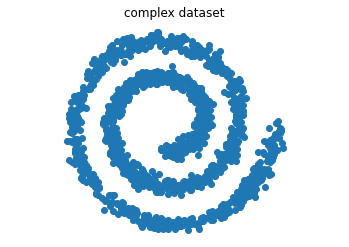

In [82]:
complex_data = generate_complexdata(True)

In [88]:
### https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
def plot_clusters(data, data_c, algorithm, args, kwds):
        
        
    fig, ax = plt.subplots(1,2, figsize = (20,10))
    
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    #colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    results = pd.DataFrame(data, columns = ["x1", "x2"])
    results["labels"] = labels
    
    plt.subplot(121)
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = labels)
    ax.set_title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
#########
    start_time = time.time()
    labels_c = algorithm(*args, **kwds).fit_predict(data_c)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    #colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    results_c = pd.DataFrame(data_c, columns = ["x1", "x2"])
    results_c["labels_c"] = labels_c
    
    plt.subplot(122)
    ax = sns.scatterplot(x=results_c.x1, y=results_c.x2, hue = labels_c)
    ax.set_title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
    
    
    
    return(labels, labels_c)

## Partitioning Clustering methods

Partitional clustering algorithms are methods used to classify data objects into multiple groups, with at minimum one element per group, based on their similarity. This is done in an intertive pocess. No object can be a member of more than one cluster. For some of theclustering algorithms of this categorie (K-Means, K-Medoids), the scientist has to specify $k$ - the number of clusters.

I will focus on four algorithms, K-Means clustering, K-Medoids clustering, Affinity Propagation Clustering, and Mean Shift clustering. Only Affinity Propagation is deterministic over runs. This simply means that when using the non-deterministic algorithms, the user could obtain different results when running the same algorithm several times over the same dataset.

Partitional clustering methods have several strengths:

+ They work well when clusters have a spherical shape.
+ They’re scalable with respect to algorithm complexity.

They also have several weaknesses:

+ They’re not well suited for clusters with complex shapes and different sizes.
+ They break down when used with clusters of different densities.
https://realpython.com/k-means-clustering-python/

### K means

K-means clutering was introduced by J. MacQueen in 1967 when he was proposing algorithms that can "paritioning an N-dimensional population into k sets" (MacQueen 1967). According to MacQueen, this algorithm produces partitions that are reasonably efficient in their within-class variance, is easily implemented and not to computationally extensice. (MacQueen) In the following section we will see that this algorithm is scaling well to large number of samples.

As explained in Section 4, as a algorithm that is performing partitional clustering, the k-means algorithm clusters $n$ objects of the dataset $X$ by trying to partition them in $k$ groups $C$ of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. The so called cost function of the k-means algorithm is the follwing: C

\begin{equation}
\sum_{i=0}^n \min_{\mu_j \in C}(||{x_i}-{\mu_j}||^2)
\end{equation}

It is defines in terms of the squared euclidean distance of each point $x_i$ to the closest cluster mean.
MIT https://piazza.com/class_profile/get_resource/hckx35ial496d5/he8g2d4n99u6ic

This requires to specify the number of clusters. The inertia criterion leads to the algorithm suffering regarding several drawbacks:
* Inertia assumes that true clusters are convex and isotropic. So it assumes globular clusters, whereas in reality this is not always the case. It is therefore not suitable for clusters with unusual shapes.

* Inertia is not normalized, meaning that we just know that a Inertia of 0 is optimal, but we cannot compare the inertia that we obtained by k-means clustering across several datasets. This is especially true for the high dimensional space, where the euclidean distance becomes inflated when the algorithm tries to learn the structur of a high dimensional dataset from a small number of observations.
https://scikit-learn.org/stable/modules/clustering.html#


Given a specified inital set of k-means $m_1$,...$m_k$, Lloyds algorithm proceeds as follows:

---
<span style="color:blue">**Llyods algorithm**:</span> 

   1. **Initialization**: The initial k-centroids are randomly picked from the dataset
   2. **Assignment**: For each point in the dataset, find the euclidean distance between the point and all centroids
   3. **Updating**: Update the value of the centroid with the new mean value
   4. **Repeat**: Repeat steps 2 and 3 until convergence is archieved. The break the loop

---
https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca




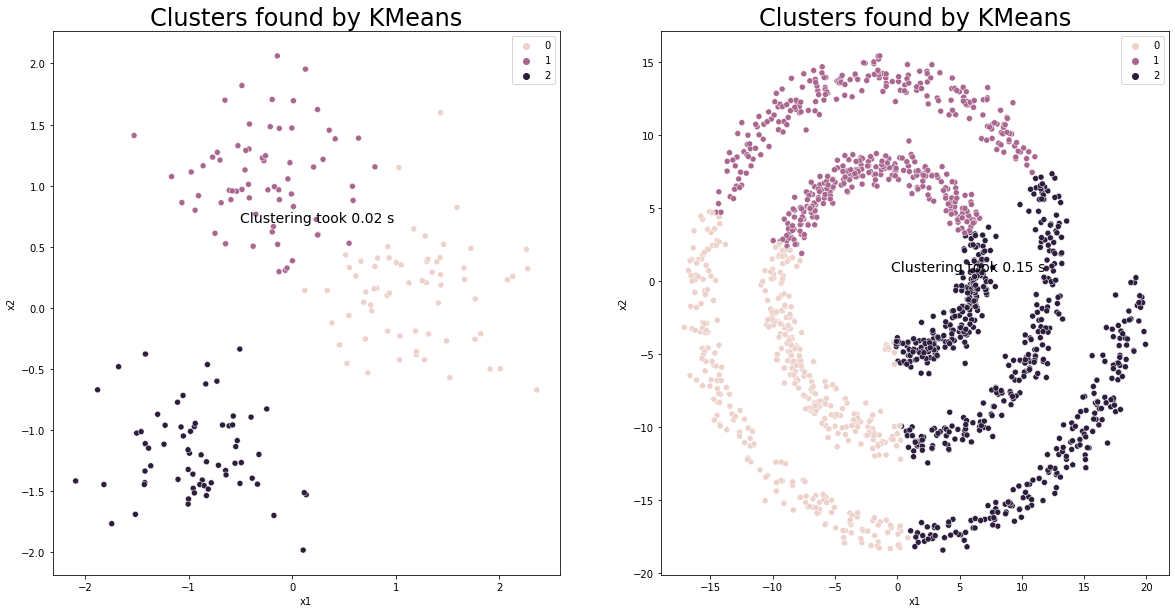

In [89]:
k_means = plot_clusters(blobs_df, complex_data, sk_cluster.KMeans, (), {'n_clusters':3,  "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42})


## K Medoids

K-Medoids clustering tackles a problem of K-Means clustering: IN K-Means Clustering, the final centroids are not interpretable since these centroids are not actuall points but the mean of all the points that were partitioned into that cluster. Therefore the coordinates of the centroids do not resemlbe reals points. K-Medoids clustering tackles this and makes the final centroids actual datapoints, which makes the final centroid intertrepatble.

The algorithm used for k-medoids clusterig is called the Partitioning Around Medoids Algorithm (PAM). It uses a greedy search which may not reuslt in the optimum solution, but is really fast. PAM proceeds as follows:

---
<span style="color:blue">**Partitioning Around Medoids Algorithm (PAM)**:</span> 

   1. **Initialization**: The initial k-medoids are randomly picked from the dataset
   2. **Assignment**: For each point in the dataset, find the euclidean distance between the point and all medoids and associate each point to the closest medoid
   3. **Updating**: Choose new centroid $M$ such that it minimizes the minimum cost function:

\begin{equation}
M_1, M_2, ..., M_k = argmin \sum_{i=1}^k \sum_{i=1} ||x-M_i||^2)
\end{equation}

   4. **Repeat**: Repeat steps 2 and 3 until convergence is archieved. The break the loop

---

https://piazza.com/class_profile/get_resource/hckx35ial496d5/he8g2d4n99u6ic

https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca

or in other words, centroids are not the actual point but the mean of points present in that cluster. Here are the coordinates of 3-centroids that do not resemble real points from the dataset.

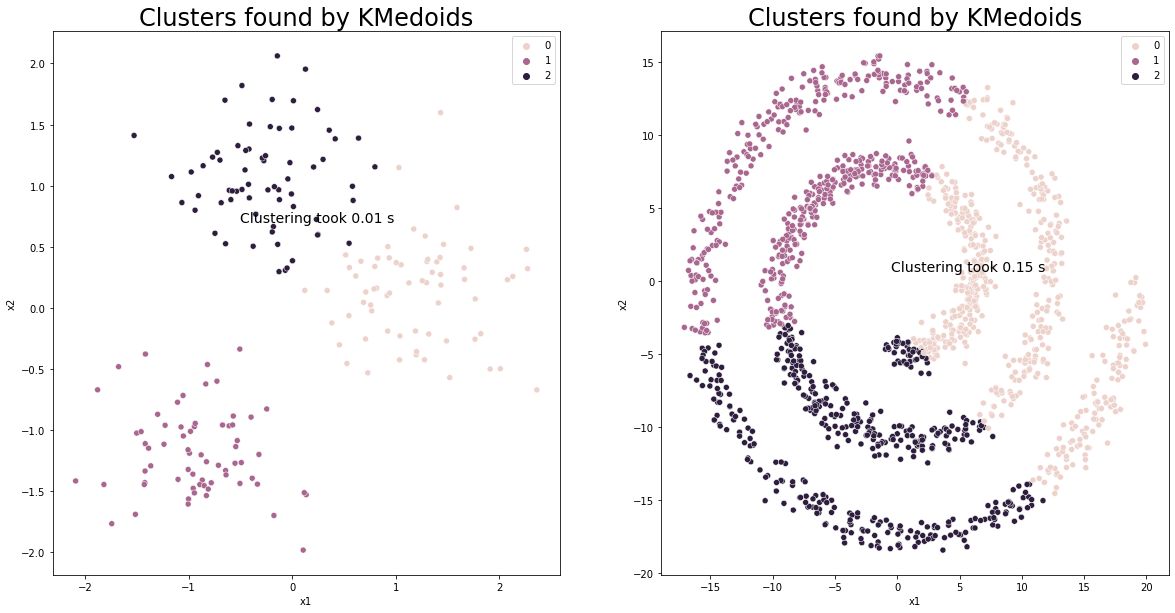

In [90]:
K_medoids = plot_clusters(blobs_df, complex_data, skx_cluster.KMedoids, (), {'n_clusters':3,  "init": "random", "max_iter": 300, "random_state": 42})

## Choosing the Appropriate Number of Clusters 
So far we looked at two algorithms that require to specify the number of clusters. How can we validate wheter we have choosen the optimal number of clusters? 

There are two methods, that are most often used as complementary evaluation techniques rather than one being preferred over the other.
https://realpython.com/k-means-clustering-python/

### The elbow method


To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE. Determining the elbow point in the SSE curve isn’t always straightforward. Therefore I use a Python package, kneed, to identify the elbow point programmatically:
https://realpython.com/k-means-clustering-python/


### The silhouette coefficient

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
How close the data point is to other points in the cluster
How far away the data point is from points in other clusters
Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.
In the scikit-learn implementation of the silhouette coefficient, the average silhouette coefficient of all the samples is summarized into one score. The silhouette score() function needs a minimum of two clusters, or it will raise an exception.
Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient:
https://realpython.com/k-means-clustering-python/

##### The following function performs k-means clustering and uses both methods to evaluate the appropriate cluster based on different generated datasets:

In [10]:
# Data generation
features, true_labels = sk_data.make_blobs(n_samples=200, centers=3, cluster_std=2.75, random_state=42)
scaler = sk_preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(features)


In [11]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}

In [12]:
def kmeans(kmeans_kwargs, kmax, centers, cluster_std):
    
   # Data generation
    features, true_labels = sk_data.make_blobs(n_samples=200, centers=centers, cluster_std=cluster_std, random_state=42)
    scaler = sk_preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(features)
    #scaled_features_2 = scaler.fit_transform(df[["x1","x2"]])
    sse = []
    for k in range(1, kmax):
        kmeans = sk_cluster.KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)


    kl = kneed.KneeLocator(range(1, kmax), sse, curve="convex", direction="decreasing")
    kl.elbow
    
    silhouette_coef = []
    for k in range(2, kmax):
        kmeans = sk_cluster.KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        score = round(sk_metrics.silhouette_score(scaled_features, kmeans.labels_),4)
        silhouette_coef.append(score)
        
    max_score = max(silhouette_coef)
    best_k = 2+silhouette_coef.index(max_score)

        
    
    fig, ax = plt.subplots(1,2, figsize = (10,5))
   
    plt.subplot(121)
    ax = sns.lineplot(x= range(1,kmax),y=sse)
    ax1 = plt.axvline(x=kl.elbow, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Ellbow Method");    

    plt.subplot(122)
    ax = sns.lineplot(x=range(2,kmax), y=silhouette_coef)
    ax1 = plt.axvline(x=best_k, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Silhouette Coefficient");
    fig.suptitle(f"k-means, Specifications: Centers: {centers}, Cluster std.: {cluster_std}", fontsize=16)
    plt.tight_layout(pad=2.5);



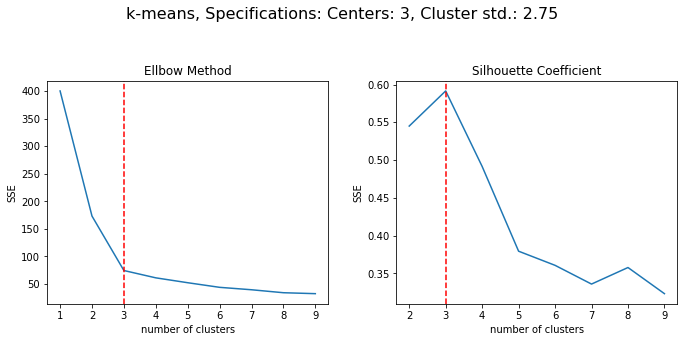

In [13]:
kmeans(kmeans_kwargs, 10, 3, 2.75);
   

https://realpython.com/k-means-clustering-python/

https://scikit-learn-extra.readthedocs.io/en/stable/modules/cluster.html#k-medoids

In [14]:
kmedoids_kwargs = { "init": "random", "max_iter": 300, "random_state": 42,}

In [15]:
def kmedoids(kmedoids_kwargs, kmax, centers, cluster_std):
   
    # Data generation
    features, true_labels = sk_data.make_blobs(n_samples=200, centers=centers, cluster_std=cluster_std, random_state=42)
    scaler = sk_preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(features)
    #scaled_features_2 = scaler.fit_transform(df[["x1","x2"]])
    sse = []
    
    for k in range(1, kmax):
        kmedoids = skx_cluster.KMedoids(n_clusters=k, **kmedoids_kwargs)
        kmedoids.fit(scaled_features)
        #print("for k: ", k, ((true_labels != kmedoids.labels_).sum())**2 / len(true_labels))
        sse.append(kmedoids.inertia_)


    kl = kneed.KneeLocator(range(1, kmax), sse, curve="convex", direction="decreasing")
    kl.elbow
    
    silhouette_coef = []
    for k in range(2, kmax):
        kmedoids = skx_cluster.KMedoids(n_clusters=k, **kmedoids_kwargs)
        kmedoids.fit(scaled_features)
        score = round(sk_metrics.silhouette_score(scaled_features, kmedoids.labels_),4)
        silhouette_coef.append(score)
        
    max_score = max(silhouette_coef)
    best_k = 2+silhouette_coef.index(max_score)

        
    
    fig, ax = plt.subplots(1,2, figsize = (10,5))

    plt.subplot(121)
    ax = sns.lineplot(x= range(1,kmax),y=sse)
    ax1 = plt.axvline(x=kl.elbow, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Ellbow Method");    

    plt.subplot(122)
    ax = sns.lineplot(x=range(2,kmax), y=silhouette_coef)
    ax1 = plt.axvline(x=best_k, animated = True, ls = "--", c = "red")
    ax.set_ylabel("SSE")
    ax.set_xlabel("number of clusters")
    ax.set_title("Silhouette Method");
    fig.suptitle(f"k-medoids, Specifications: Centers: {centers}, Cluster std.: {cluster_std}", fontsize=16)
    plt.tight_layout(pad=2.5);

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(


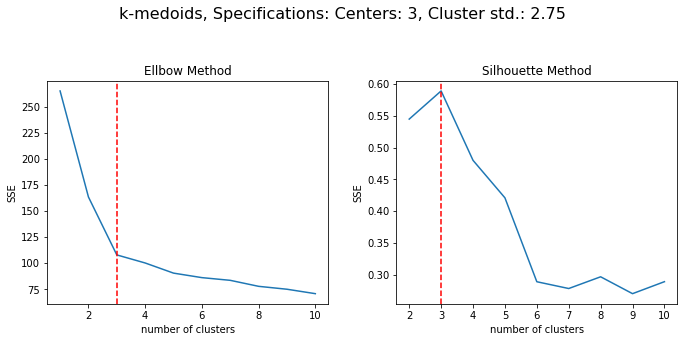

In [16]:
kmedoids(kmedoids_kwargs, 11, 3,2.75)

## Affinity Propagation

Affinity Propagation is a newer and modern clustering algorithm that uses a graph based approach. It aims to discover the datappoints taht represent the whole dataset. This is done since the algorithm let the points ‘vote’ themselves on their preferred ‘exemplar’ based on the maximal value of the responsibility and availability of each data point. Responsibility of a data point refers to wheter it is suited to be assigned to an exemplar; Availability measures how well a data point is suiteed to be an exemplar.

https://digitalcommons.georgiasouthern.edu/cgi/viewcontent.cgi?article=3029&context=etd

This is done by passing messages between the data points until these maximums are archieved. We do not need to specify $k$ since the optimal number of clusters is computed through updating the responsibility and availability of all data points of the dataset. The algorithm then returns data points as a set of ‘exemplars’ from which the clusters are then created similar to what K-Means does: Each point is assigned to the cluster of it’s nearest exemplar. 
https://digitalcommons.georgiasouthern.edu/cgi/viewcontent.cgi?article=3029&context=etd

Affinity Propagation has some advantages over K-Means:

* First, since the points vote themselves on their preferred exemplars, the user doesn’t need to specify the number of clusters. 

* Second, the algorithm allows for non-metric dissimilarities which is important if the user wants to work with data that is not naturally embedded in a metric space

* Finally, Affinity Propagation offers better stability runs

Since Affinity Propagation partitions the data, problems with 'noisy' data can be expected. In addition to this, Affinity Propagations needs the user to specify 'preference' and 'damping' parameters, which can be challenging. Additionally, since the algorithm supports non-metric dissimilarities, it tends to be slow. Overall, Affinity Propagation does not really provide an improvement in normal settings unless the choice of the specific preference and damping parameters are easier than specify the number of clusters.
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#

Because the algorithm works without specifying $k$ initial clusters, there is no application for the elbow and silhouette method.
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#mean-shift

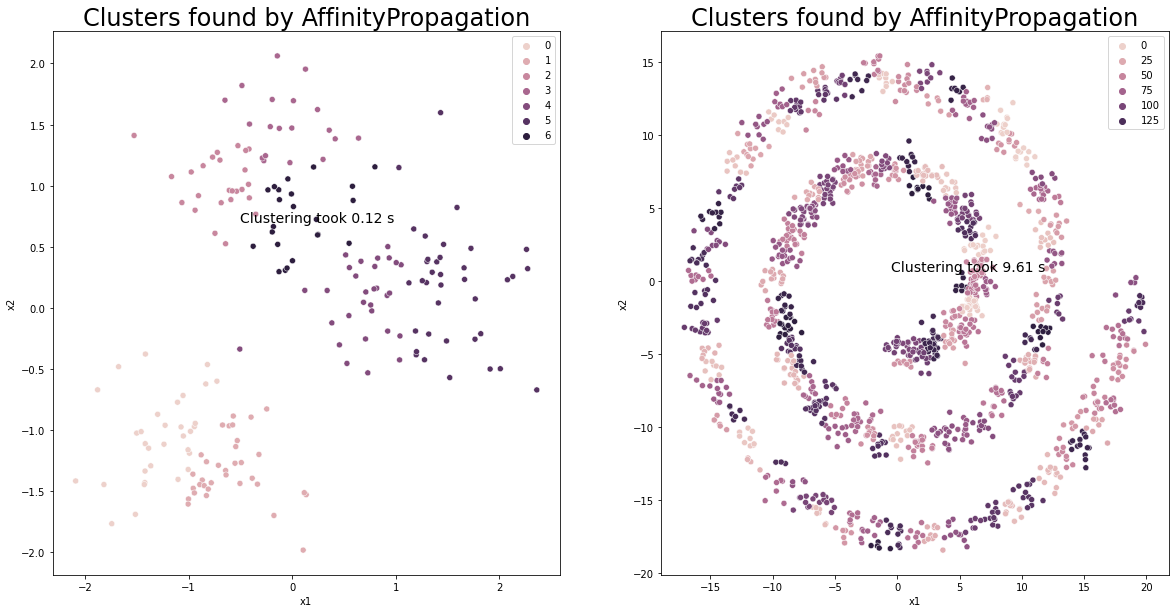

In [91]:
xx= plot_clusters(blobs_df, complex_data, sk_cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95, "max_iter": 400, "random_state": 42})

cluster_allbool, default=True
If true, then all points are clustered, even those orphans that are not within any kernel. Orphans are assigned to the nearest kernel. If false, then orphans are given cluster label -1.

## Mean Shift Clustering

This algorithm aims to discover blobs in a sample. Like K-Means, it is a centroid based algorithm. It works by updating candidates for centroids to be the means of points within a given region. 

It uses a kernel function $K(x_i - x)$ which determines the weights of all points near the centroid for the computation of the mean. You can think about this kernel as a circular sliding window with the a radius that is determined by the bandwith parameter. In the implementation at hand, if this bandwith parameter is not specified it estimated within the function.

Given a centroid $x_i$ at iteration t, it is updated according to

\begin{equation}
x_i^{t+1} = m(x_i^t) = \frac {\sum_{x_j^t in N(x_i^t)} K(x_j^t - x_i^t)x_j^t} {\sum_{x_j^t in N(x_i^t)} K(x_j^t - x_i^t)}
\end{equation}


---
<span style="color:blue">**Mean Shift Clustering Algorithm**:</span> 

   1. **Initialization**: The initial centroids are randomly picked from the dataset according to the parameters. 
   2. **Assignment**: Calculate the mean of all points that lie within the "window"
   3. **Updating**: Choose new centroid $M$ such that the window is lying on the location of the mean.
   4. **Repeat**: Repeat steps 2 and 3 until convergence (current location of window and new centroid coincides) is archieved. Then break the loop.

---

As you see below, the user can instruct the algorithm to label orphans with the label _-1_. Orphans are defined as points that do not lie within a kernel. 

##### Positive Aspects:
* User does not have to specify the number of clusters
* Output not dependedn on initialization
* Simple implementation in Python: Bandwith parameter (radius of kernel) is estimated within the function if not specified

##### Negative Aspects
* Self-selection of Bandwith not trivial!
* Designed to detect "blobs" within data, struggles with complex data structures

https://iq.opengenus.org/mean-shift-clustering-algorithm/

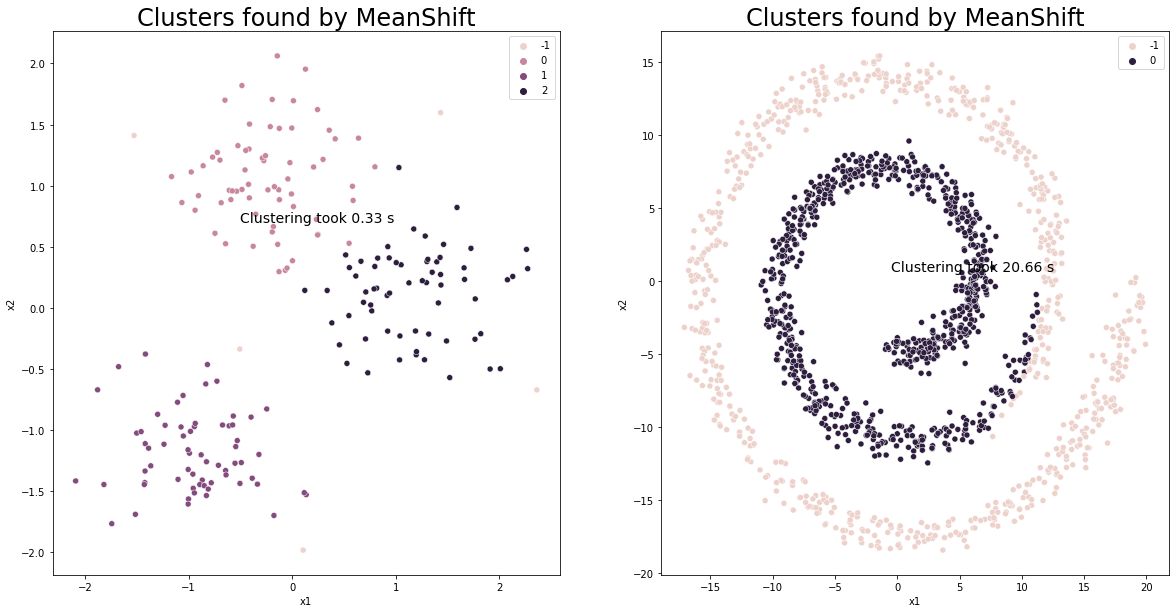

In [92]:
xxx= plot_clusters(blobs_df, complex_data, sk_cluster.MeanShift, {}, {'cluster_all':False});

## Hierachial Clustering

Hierarchical clustering determines cluster assignments by building a hierarchy. The data is first clustered in some subgroups. This is implemented by either a bottom-up or a top-down approach. There are two families of hierachical clustering algorithms:

* Agglomerative clustering is the bottom-up approach as one moves up in the hierachy. It merges the two points that are the most similar until all points have been merged into a single cluster or the desired number of clusters is obtained.

---
<span style="color:blue">**Agglomerative Clustering**:</span> 

   1. All data points are in their own cluster
   2. Two nearest clusters are joined to form single cluster
   3. Repeat step 2 until until desired number of clusters is obtained

---

* Divisive clustering is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain.

---
<span style="color:blue">**Divisive Clustering**:</span> 

   1. All data points are assigne in one single cluster
   2. Cluster is partitioned into two least similar clusters
   3. Repeat step 2 to form new clusters until desired number of clusters is obtained

---



Python only provides Agglomerative Clustering algorithms in its libraries. So in the following I will focus only on the bottom-up approach of hierachical clustering. The algorithms of the families differ in their linkage criterion.
https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-hierarchical-clustering
There are several different metrics used for the linkage:

* Ward - minimizes the summ of squared differences within all clusters
* Maximum / Complete linkage - minimizes the maximum distance between observations of pairs of clusters
* Average linkage - minimizes average of the distances between all observations of pairs of clusters
* Single linkage - minimizes distance between closest observations of pairs of clusters

The hierachical structure of the results can be represented using a dendrogramm. This provides a tool that is useful for understanding the structure of the data.


https://scikit-learn.org/stable/modules/clustering.html


In [107]:
def plot_Agglomerative_clusters(data,data_c, n, args):
    
    
    kwds = {'n_clusters':n, 'linkage':'ward'}
    fig, ax = plt.subplots(4,2, figsize = (20,40))
  
    start_time = time.time()
    labels = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data)
    end_time = time.time()
    
    results = pd.DataFrame(data, columns = ["x1", "x2"])
    results["labels"] = labels
    
    plt.subplot(421)
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = labels)
    ax.set_title('Clusters found using ward' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
##
    kwds = {'n_clusters':n, 'linkage':'ward'}
  
    start_time = time.time()
    labels_c = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data_c)
    end_time = time.time()
    
    results_c = pd.DataFrame(data_c, columns = ["x1", "x2"])
    results_c["labels_c"] = labels_c
    
    plt.subplot(422)
    ax = sns.scatterplot(x=results_c.x1, y=results_c.x2, hue = labels_c)
    ax.set_title('Clusters found using ward' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

###########
    kwds = {'n_clusters':n, 'linkage':'complete'}
    start_time = time.time()
    labels = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data)
    end_time = time.time()
    
    results = pd.DataFrame(data, columns = ["x1", "x2"])
    results["labels"] = labels
    
    plt.subplot(423)
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = labels)
    ax.set_title('Clusters found using complete linkage' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
##
    kwds = {'n_clusters':n, 'linkage':'complete'}
  
    start_time = time.time()
    labels_c = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data_c)
    end_time = time.time()
    
    results_c = pd.DataFrame(data_c, columns = ["x1", "x2"])
    results_c["labels_c"] = labels_c
    
    plt.subplot(424)
    ax = sns.scatterplot(x=results_c.x1, y=results_c.x2, hue = labels_c)
    ax.set_title('Clusters found using complete linkage' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
###########
    kwds = {'n_clusters':n, 'linkage':'average'}
    start_time = time.time()
    labels = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data)
    end_time = time.time()
    
    results = pd.DataFrame(data, columns = ["x1", "x2"])
    results["labels"] = labels
    
    plt.subplot(425)
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = labels)
    ax.set_title('Clusters found using average linkage' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
##
    kwds = {'n_clusters':n, 'linkage':'average'}
  
    start_time = time.time()
    labels_c = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data_c)
    end_time = time.time()
    
    results_c = pd.DataFrame(data_c, columns = ["x1", "x2"])
    results_c["labels_c"] = labels_c
    
    plt.subplot(426)
    ax = sns.scatterplot(x=results_c.x1, y=results_c.x2, hue = labels_c)
    ax.set_title('Clusters found using average linkage' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
###########

    kwds = {'n_clusters':n, 'linkage':'single'}
    start_time = time.time()
    labels = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data)
    end_time = time.time()
    
    results = pd.DataFrame(data, columns = ["x1", "x2"])
    results["labels"] = labels
    
    plt.subplot(427)
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = labels)
    ax.set_title('Clusters found using single linkage' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
##
    kwds = {'n_clusters':n, 'linkage':'single'}
  
    start_time = time.time()
    labels_c = sk_cluster.AgglomerativeClustering(*args, **kwds).fit_predict(data_c)
    end_time = time.time()
    
    results_c = pd.DataFrame(data_c, columns = ["x1", "x2"])
    results_c["labels_c"] = labels_c
    
    plt.subplot(428)
    ax = sns.scatterplot(x=results_c.x1, y=results_c.x2, hue = labels_c)
    ax.set_title('Clusters found using single linkage' , fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
###########

        

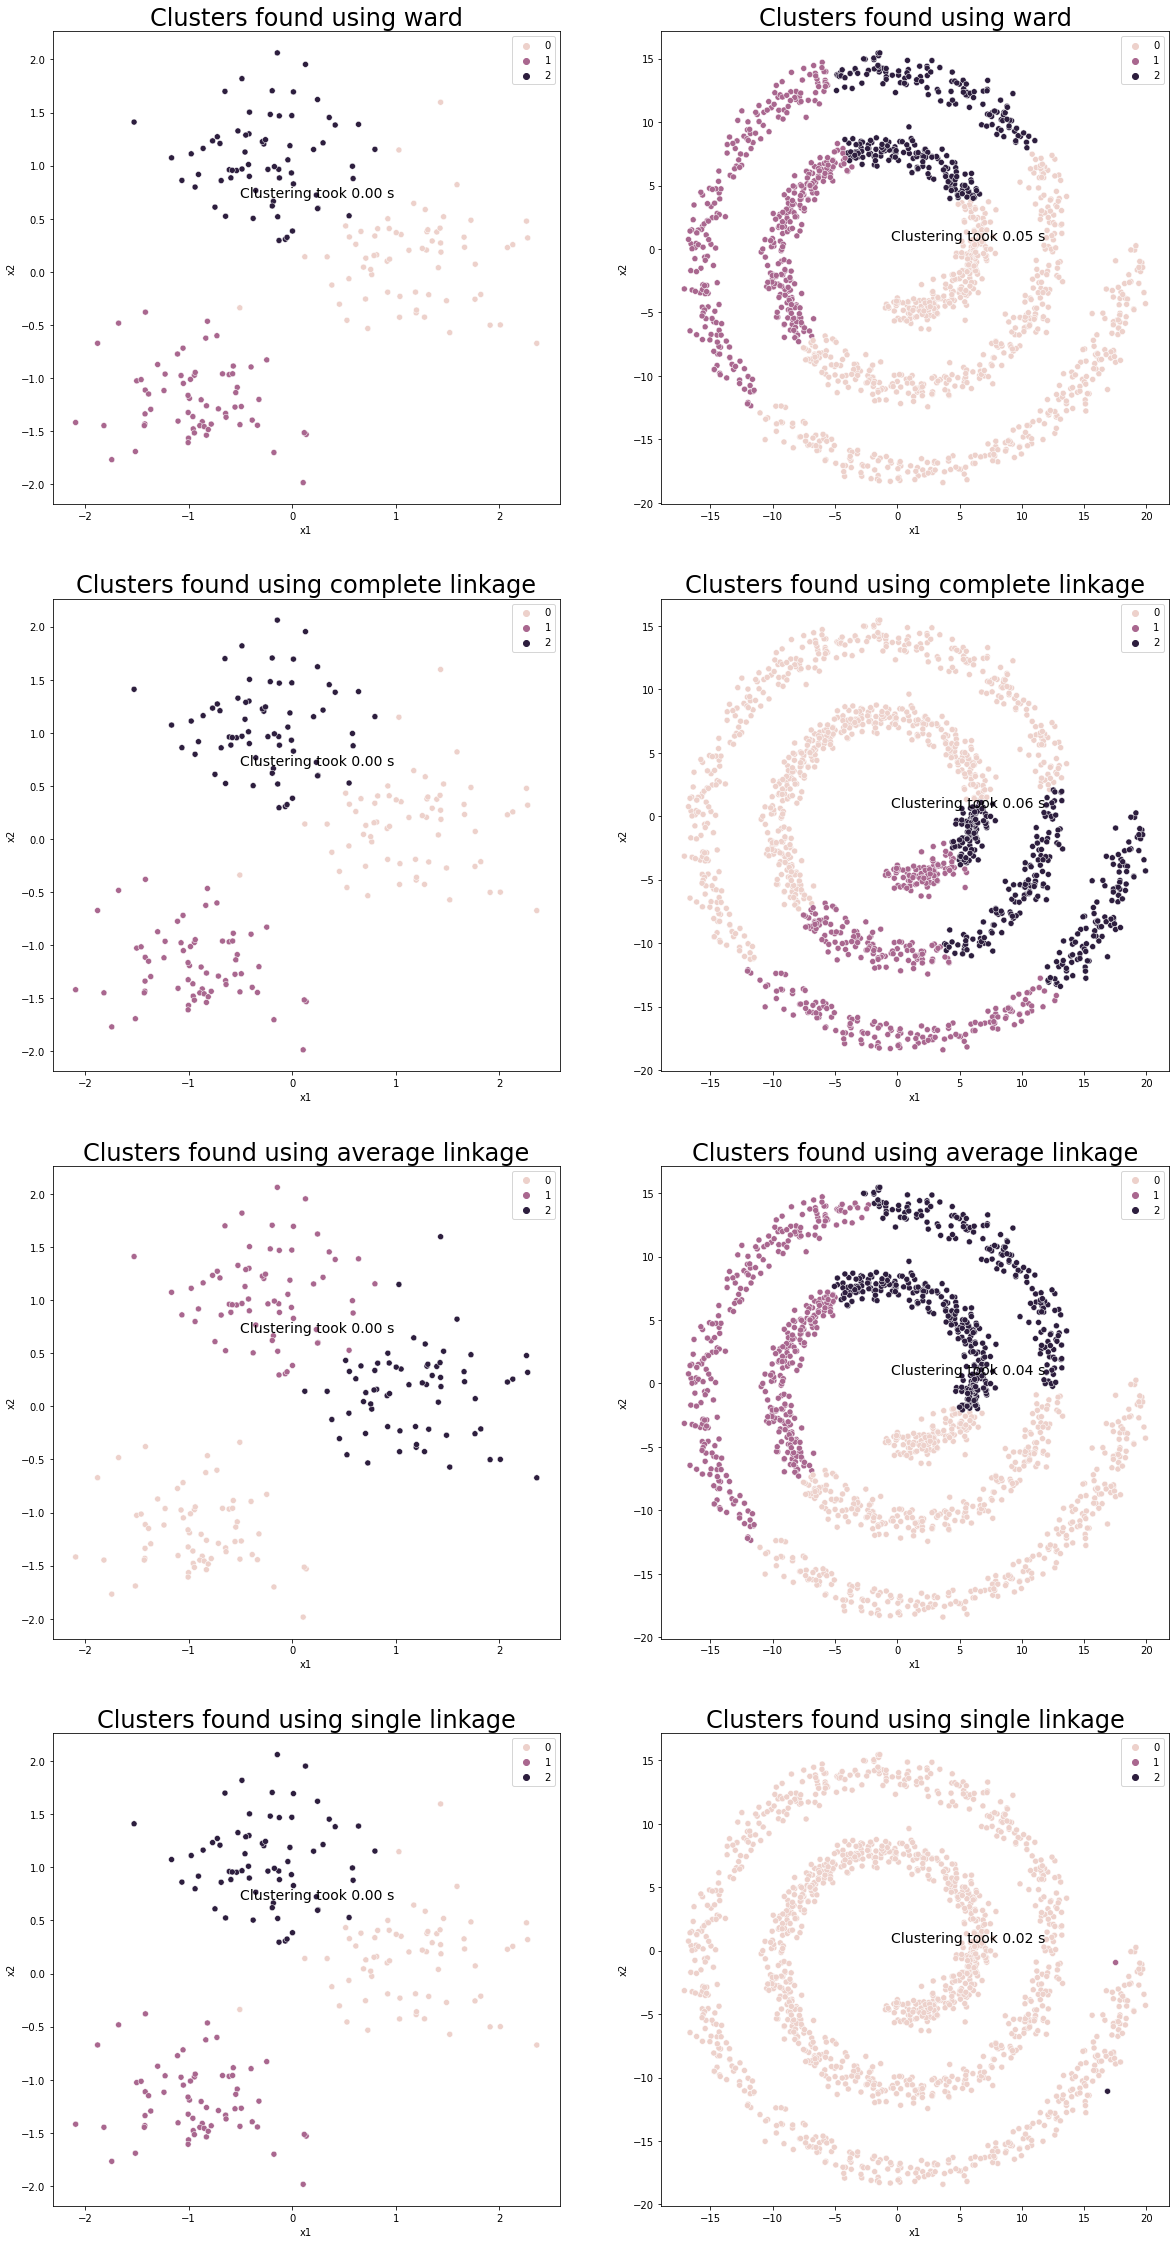

In [108]:
plot_Agglomerative_clusters(blobs_df, complex_data, 3, ())

## Performance and Scaling

So far I described several clustering algorithms. This ection will shed light on the issue of performance and scalability. Some might thik tht this topic does not really matter nowadays, but as I will show, it still does for some algorithms that we discussed. 

Performance and Scalability depends both on the algorithm itself, but also on the implementation. Obviously a well written implementation in C or C++ will beat my implementation with Pyton. But besides the choice of the language that we use, there are other factors that have a large impact on the performance. The structure of the dataset at hand impacts the performance by a large amount, and can even significanty change asymptotic performance. So for some researchers with limited computational resources or for Data Scientist that have to process hugh amounts of data everyday, this poses a serious constraint to the range of clustering algorithms that are feasible for them.

To provide a comparison of the clustering algorithms with regard to the performance and scaleability, I coded a benchmarking function that gives us the performance for each algorithm with varying dataset sizes. Because some clustering algorithms have performance that can vary quite a lot depending on the exact nature of the dataset we’ll also need to run several times on randomly generated datasets of each size so as to get a better idea of the average case performance.----


In [21]:
dataset_sizes = np.hstack([np.arange(1, 4) * 500])#, np.arange(3,7) * 1000, np.arange(4,10) * 2000])
dataset_sizes

array([ 500, 1000, 1500])

In [22]:
def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = pd.DataFrame(np.nan * np.ones((len(dataset_sizes), sample_size)), columns = ["nobs","time"])
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sk_data.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)

            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            
            # create list to temporarily store results
            h_result = []
            h_result.append(time_taken)
            
        # calculate mean of time taken and add to result DataFRame
        result.loc[index, "time"] = (sum(h_result)/len(h_result))
        result.loc[index, "nobs"] = size

    # Return the result as a dataframe for easier handling with seaborn afterwards
    #return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                  # result.flatten()]).T, columns=['x','y'])
    return(result)

In [23]:
kwargs_random = {"random_state": 42}

In [110]:
k_means = sk_cluster.KMeans(10, **kwargs_random)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

k_medoids = skx_cluster.KMedoids(**kwargs_random)
k_medoids_data = benchmark_algorithm(dataset_sizes, k_medoids.fit, (), {})
#{'n_clusters':3,  "init": "random", "max_iter": 300, "random_state": 42})


mean_shift = sk_cluster.MeanShift(10)
mean_shift_data = benchmark_algorithm(dataset_sizes, mean_shift.fit, (), {})

affinity_propagation = sk_cluster.AffinityPropagation(**kwargs_random);
affinity_propagation_data = benchmark_algorithm(dataset_sizes, affinity_propagation.fit, (), {});

agglomarative_clustering = sk_cluster.AgglomerativeClustering();
agglomarative_clustering_data = benchmark_algorithm(dataset_sizes, agglomarative_clustering.fit, (), {});

dbscan = sk_cluster.DBSCAN()
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})



#labels = algorithm(*args, **kwds).fit_predict(data)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass bandwidth=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
 

In [111]:
agglomarative_clustering_data

nobs      time
0   500.0  0.006981
1  1000.0  0.034905
2  1500.0  0.060838

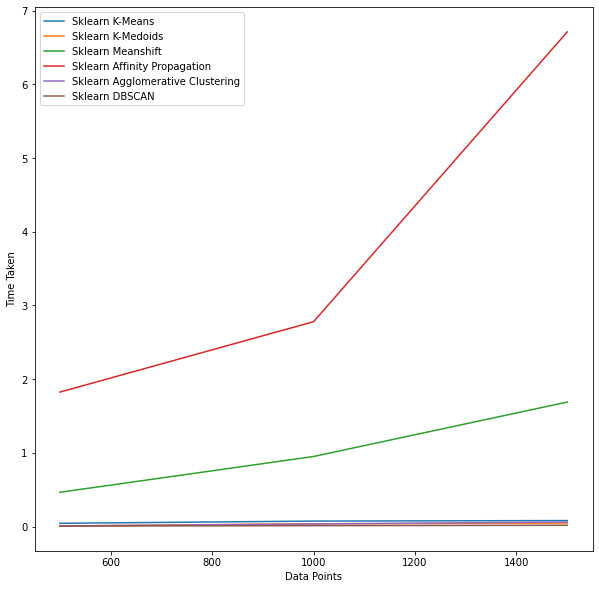

In [113]:
fig,ax = plt.subplots(figsize = (10,10))
ax = sns.lineplot(x= 'nobs', y='time', data=k_means_data, label='Sklearn K-Means')
ax = sns.lineplot(x= 'nobs', y='time', data=k_medoids_data, label='Sklearn K-Medoids')
ax = sns.lineplot(x= 'nobs', y='time', data=mean_shift_data, label='Sklearn Meanshift')
ax = sns.lineplot(x= 'nobs', y='time', data=affinity_propagation_data, label='Sklearn Affinity Propagation')
ax = sns.lineplot(x= 'nobs', y='time', data=agglomarative_clustering_data, label='Sklearn Agglomerative Clustering')
ax = sns.lineplot(x= 'nobs', y='time', data=dbscan_data, label='Sklearn DBSCAN')
ax.set_xlabel("Data Points")
ax.set_ylabel("Time Taken")
plt.plot();


## Validation

The most important issue in clustering is to evaluate the results to identify the clusters that fit the data the best. Optimally, clustering identifys clusters whose members are similar and well seperated from other clusters. Visualization is key, thats why I invested time in plotting and visualizing all the different algorithms that I introduced. Different algorithms differ regarding:

* feature of data


* parameters choosen or estimated by user

##### There are three ways to investigate cluster validity.

* External criteria - The user evaluates the results of his analysis based on a pre-specified structure, which is imposed on a data set and reflects our intuition about the structure. 

* internal criteria - The user evaluates the results in terms of quantities that are set by the algorithm and the dataset themselves

* Relative criterion - The user evaluates the structure of his result by comparing it to other clustering results that are calculated by the same algorithm but with different parameter values. The comparison is done with respect to:
    * Compactness - the distances of observations within a cluster should be as small as possible 
    * Separation - the clusters themselves are optimally widely spreaded
    
    
https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index


https://www.datanovia.com/en/lessons/cluster-validation-statistics-must-know-methods/

# Simulation Study

# Empirical Application

### Literature

(MacQueen 1967)(https://projecteuclid.org/ebooks/berkeley-symposium-on-mathematical-statistics-and-probability/Proceedings%20of%20the%20Fifth%20Berkeley%20Symposium%20on%20Mathematical%20Statistics%20and%20Probability,%20Volume%201:%20Statistics/chapter/Some%20methods%20for%20classification%20and%20analysis%20of%20multivariate%20observations/bsmsp/1200512992)
